# PROJET **CO2** - Modeles de REGRESSION



### Presentation

L'idée générale est:
1. De tester différents modèles en augmentant progressivement leur complexité, pour comparer les résultats et robustesse. => Selection du ou des meilleurs modèles
2. Ensuite de chercher à optimiser le modèle final retenu (recherche des meilleurs parametres)
3. Enfin, on s'interessera a la "feature importance" et interprétabilité du modèle final retenu


Pour garder ce Notebook présentable et compréhensible, il suit notre démarche chronologique, et ne représente donc pâs un code optimum. Il est plutot construit comme un journal de bord.  
Les études et recherches complémentaires qui ont permit d'optimiser le code ou de pousser certaines investiguations se trouvent pour information en seconde partie du notebook 

# Chargement des données et des modules

In [1]:
## Montage Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Import des libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML: sklearn + xgboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import xgboost as xgb
import pickle      

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [ ]:
# se placer dans '/content/gdrive/MyDrive/ROOT/' pour avoir des chemins relatifs

%cd "/content/gdrive/MyDrive/ROOT/"
%pwd

In [ ]:
# Lecture du dataset preprocessed  France+Allemagne 2021: 6,3 Millions de éhicules

df = pd.read_pickle('./Dataset/c02_fr&al_21_v04.pkl')

In [5]:
# Lecture du dataset réduit pour test: 

# Noms
name_10 = 'co2_prepro_10_percen.pkl'
name_2e5 = 'c02_prepro_reduit_2e5.pkl'

# 630 000 véhicules
# df = pd.read_pickle('./Dataset/'+name_10)

# 200 000 vehicules
df = pd.read_pickle('./Dataset/'+name_2e5)

In [6]:
# test
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 5742261 to 5386537
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   CategoryOf                        200000 non-null  int64   
 1   MassRunningOrder                  200000 non-null  float32 
 2   Co2                               200000 non-null  float32 
 3   EngineCapacity                    200000 non-null  float32 
 4   EnginePower                       200000 non-null  float32 
 5   InnovativeTechnology              200000 non-null  float64 
 6   InnovativeEmissionsReductionWltp  200000 non-null  float32 
 7   FuelConsumption                   200000 non-null  float32 
 8   ElectricRange                     200000 non-null  float32 
 9   Pool_BMW                          200000 non-null  int32   
 10  Pool_FORD                         200000 non-null  int32   
 11  Pool_HYUNDAI                      200

# Modele 1: Regression Lineaire - v1

## Préparation des données
Sur le dataset df chargé, nettoyage et get_dummies sont déja faits (etape préprocessing)

In [9]:
# info
df.columns

Index(['CategoryOf', 'MassRunningOrder', 'Co2', 'EngineCapacity',
       'EnginePower', 'InnovativeTechnology',
       'InnovativeEmissionsReductionWltp', 'FuelConsumption', 'ElectricRange',
       'Pool_BMW', 'Pool_FORD', 'Pool_HYUNDAI', 'Pool_HYUNDAI MOTOR EUROPE',
       'Pool_KIA', 'Pool_MAZDA-SUBARU-SUZUKI-TOYOTA', 'Pool_MERCEDES-BENZ',
       'Pool_RENAULT-NISSAN-MITSUBISHI', 'Pool_STELLANTIS', 'Pool_TESLA',
       'Pool_TESLA-HONDA-JLR', 'Pool_VOLKSWAGEN', 'Pool_VW-SAIC',
       'Fuel_DIESEL', 'Fuel_DIESEL/ELECTRIC', 'Fuel_ETHANOL', 'Fuel_LPG',
       'Fuel_NATURALGAS', 'Fuel_PETROL', 'Fuel_PETROL/ELECTRIC', 'Co2Grade'],
      dtype='object')

In [7]:
# info
column_list = []
display(df.describe())

,CategoryOf,MassRunningOrder,Co2,EngineCapacity,EnginePower,InnovativeTechnology,InnovativeEmissionsReductionWltp,FuelConsumption,ElectricRange,Pool_BMW,Pool_FORD,Pool_HYUNDAI,Pool_HYUNDAI MOTOR EUROPE,Pool_KIA,Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,Pool_MERCEDES-BENZ,Pool_RENAULT-NISSAN-MITSUBISHI,Pool_STELLANTIS,Pool_TESLA,Pool_TESLA-HONDA-JLR,Pool_VOLKSWAGEN,Pool_VW-SAIC,Fuel_DIESEL,Fuel_DIESEL/ELECTRIC,Fuel_ETHANOL,Fuel_LPG,Fuel_NATURALGAS,Fuel_PETROL,Fuel_PETROL/ELECTRIC
count,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06,6.320821e+06
mean,4.280805e-02,1.474063e+03,1.289436e+02,1.571422e+03,1.080105e+02,7.457349e-01,1.141907e+00,5.630543e+00,6.089362e+00,8.627661e-02,4.444881e-02,1.633601e-02,1.750105e-02,2.943162e-02,6.967655e-02,6.654848e-02,1.523277e-01,2.222725e-01,4.951414e-03,5.184453e-03,1.620699e-01,1.229748e-01,2.620796e-01,4.658256e-03,6.620659e-03,1.770672e-02,8.877011e-04,6.137130e-01,9.433411e-02
std,2.024241e-01,3.148942e+02,4.243578e+01,5.329268e+02,5.224067e+01,4.354473e-01,7.811802e-01,1.730786e+00,1.853909e+01,2.807721e-01,2.060901e-01,1.267641e-01,1.311288e-01,1.690130e-01,2.546011e-01,2.492384e-01,3.593383e-01,4.157734e-01,7.019187e-02,7.181626e-02,3.685150e-01,3.284084e-01,4.397657e-01,6.809227e-02,8.109764e-02,1.318833e-01,2.978109e-02,4.868977e-01,2.922930e-01
min,0.000000e+00,9.100000e+02,1.200000e+01,8.750000e+02,4.400000e+01,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.248000e+03,1.180000e+02,1.199000e+03,7.400000e+01,0.000000e+00,0.000000e+00,5.100000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.421000e+03,1.300000e+02,1.498000e+03,9.600000e+01,1.000000e+00,1.200000e+00,5.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,0.000000e+00,1.649000e+03,1.450000e+02,1.968000e+03,1.180000e+02,1.000000e+00,1.900000e+00,6.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,3.530000e+03,5.720000e+02,7.993000e+03,1.177000e+03,1.000000e+00,4.500000e+00,2.520000e+01,1.280000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [35]:
# Separate variables from target and Select the variables from to work with

y = df['Co2']
X = df.drop(['Co2', 'Co2Grade', 'FuelConsumption'], axis=1)

In [63]:
# Separating into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)

In [64]:
# Standarization

scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# scaler = None

X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

In [8]:
# Saving/Loading Training and Test Sets - Pour l'exemple: trop gros fichiers alors que le preprocess est rapide

# Saving / Loading
# X_train.to_pickle('Dataset/X_train_reg.pkl')
# X_train = pd.read_pickle('Dataset/X_train_reg.pkl')
# ..etc

## Model training and Scoring

In [65]:
# model configuration ant training

lr = LinearRegression()
lr.fit(X_train, y_train)

# train and test predict

pred = lr.predict(X_train)
pred_test = lr.predict(X_test)

# Commentaire:
# R2score = 0.89

In [103]:
# Fac: model configuration ant training 2 (avec calcul du temps de fit)

temps_debut = time.time()

# model configuration ant training
lr = LinearRegression()
lr.fit(X_train, y_train)

# train and test predict
pred = lr.predict(X_train)
pred_test = lr.predict(X_test)

# fit time
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")

# Model saving - todo (with time training)

# Commentaire:
# le code prends 11s sur Colab_GPU_T4
# le code prends 4s en local
# R2score = 0.89


Le code a pris 3.9753923416137695 secondes pour s'exécuter.


In [66]:
# SCORING initial

print('score R2 train :',lr.score(X_train, y_train))
print('score R2 test :',lr.score(X_test, y_test))

mse_train = mean_squared_error(y_train, pred)
mse_test = mean_squared_error(y_test, pred_test)
print("MSE train:", mse_train)
print("MSE test:", mse_test)

mae_train = mean_absolute_error(y_train, pred)
mae_test = mean_absolute_error(y_test, pred_test)
print("MAE train:", mae_train)
print("MAE test:", mae_test)

def Mape(y,y_pred):
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mape

print("MAPE train:", Mape(y_train, pred))
print("MAPE test:", Mape(y_train, pred))


score R2 train : 0.8931644030904975
score R2 test : 0.8932404830947852
MSE train: 195.17134477793897
MSE test: 194.48169314989184
MAE train: 9.980682352709328
MAE test: 9.961238917221284
MAPE train: 10.251115904134423
MAPE test: 10.251115904134423


In [ ]:
# results = Valeurs réelle / Valeurs prédites / residus / residus en %. Exemples

results = pd.DataFrame({'Co2_reel': y_test, 'Co2_pred': pred_test, 'residus': y_test-pred_test,'residus_percent': (y_test-pred_test)/y_test*100 }, index=X_test.index)
results = results.round(1).sort_values(by='Co2_reel')
results.sample(15).sort_values(by='Co2_reel')

In [189]:
# Affichage d'exemples de prédictions
# results = Valeurs réelle / Valeurs prédites / Residus. 

results = pd.DataFrame({'Co2_reel': y_test, 'Co2_pred': pred_test, 'residus': y_test-pred_test}, index=X_test.index)
results = results.round(1).sort_values(by='Co2_reel')
results.sample(15).sort_values(by='Co2_reel')

,Co2_reel,Co2_pred,residus
7205633,30.0,30.299999,-0.3
3115402,32.0,32.000000,-0.0
6392737,34.0,33.099998,0.9
4440574,92.0,87.099998,4.9
6132234,114.0,114.699997,-0.7
792656,119.0,117.800003,1.2
7460566,121.0,119.699997,1.3
6117693,123.0,123.400002,-0.4
3507948,134.0,134.100006,-0.1
5760239,134.0,135.800003,-1.8


Text(0, 0.5, 'Co2_prédit')

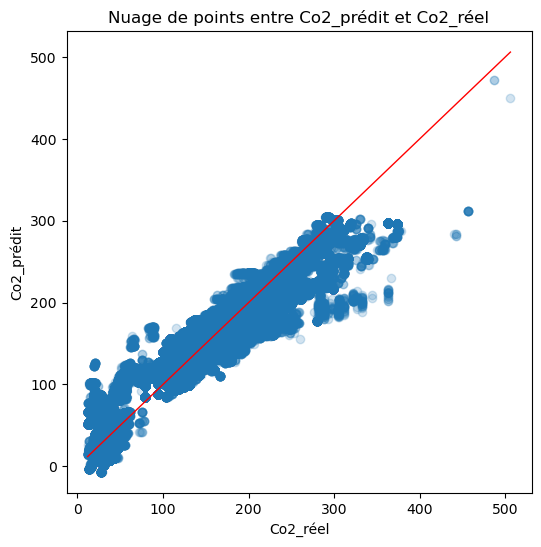

In [12]:
# Etude des résidus et valeurs abberantes

plt.figure(figsize=(6,6))
plt.scatter( results.Co2_reel, results.Co2_pred, alpha = 0.1)
plt.plot((results.Co2_reel.min(), results.Co2_reel.max()), (results.Co2_reel.min(), results.Co2_reel.max()), lw = 1, color ='red');
plt.title('Nuage de points entre Co2_prédit et Co2_réel')
plt.xlabel('Co2_réel')
plt.ylabel('Co2_prédit')

Text(0, 0.5, 'Co2_réel')

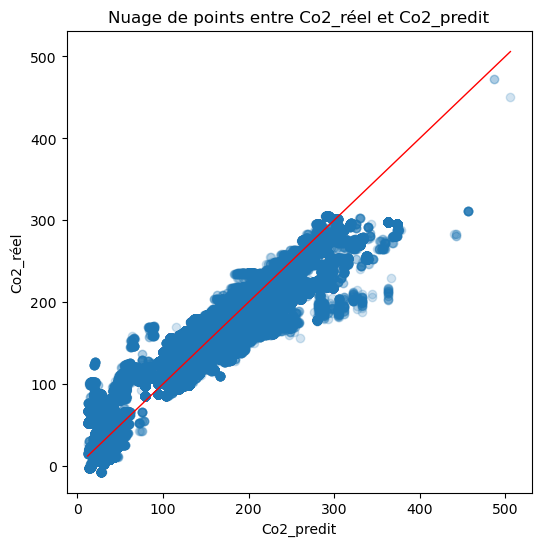

In [13]:
# Etude des résidus et valeurs abberantes v2
# Avec inversion des axes x/y

plt.figure(figsize=(6,6))
plt.scatter( results.Co2_reel, results.Co2_pred, alpha = 0.1)
plt.plot((results.Co2_reel.min(), results.Co2_reel.max()), (results.Co2_reel.min(), results.Co2_reel.max()), lw = 1, color ='red');
plt.title('Nuage de points entre Co2_réel et Co2_predit')
plt.xlabel('Co2_predit')
plt.ylabel('Co2_réel')


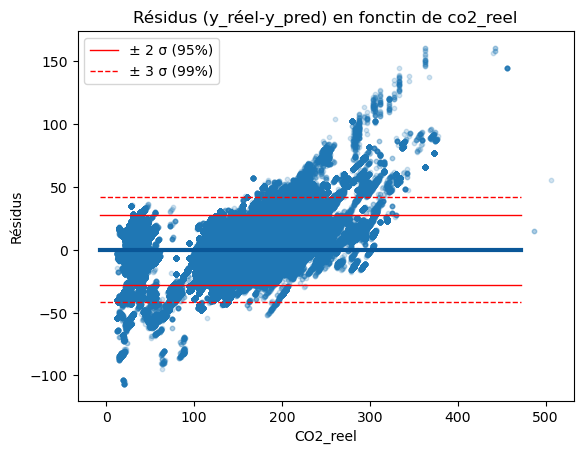

In [174]:
## Graphe résidus en fonction de pred_train (valeurs ajustées):
residus = results.residus

plt.figure(figsize=(6,5))
plt.scatter(results.Co2_reel, results.residus, alpha = 0.1)
plt.plot((pred_test.min(), pred_test.max()), (0, 0), lw=3, color='red')
plt.plot((pred_test.min(), pred_test.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '± 2 σ') 
plt.plot((pred_test.min(), pred_test.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '± 3 σ')
plt.plot((pred_test.min(), pred_test.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_test.min(), pred_test.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus (y_reel-y_pred) en fonction de co2_reel')
plt.xlabel('co2_reel')
plt.ylabel('Résidus')
plt.legend()
print("2 σ = ",2*residus.std())
print("3 σ = ",3*residus.std())

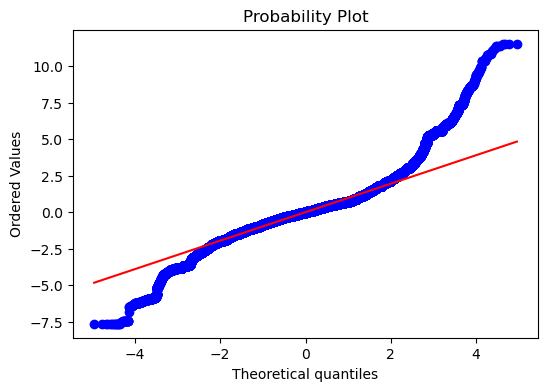

In [122]:
# diagramme Quantile-Quantile ou (Q-Q plot)
# sur les residus normalises

from scipy import stats

residus_norm = preprocessing.scale(results.residus)
plt.figure(figsize=(6,4))
stats.probplot(residus_norm, plot=plt, dist='norm')
plt.show()

Text(0.5, 0, 'résidus')

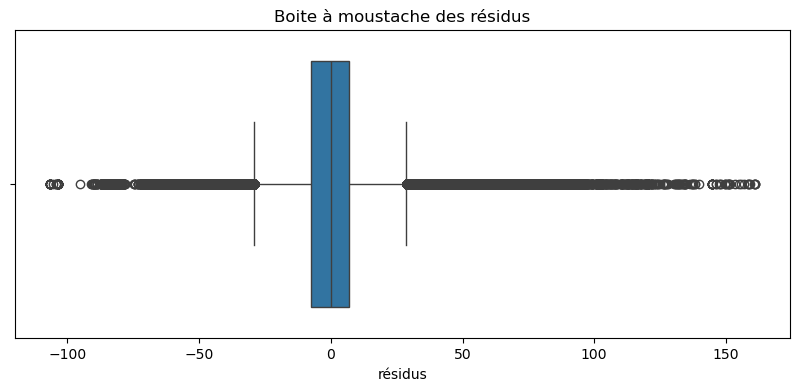

In [201]:
# boxplot des residus

plt.figure(figsize=(10,4))
sns.boxplot(results.residus, orient='h')
plt.title('Boite à moustache des résidus')
plt.xlabel('résidus')

table des coef


,coef_va,coef
Fuel_PETROL,2.612792e+12,-2.612792e+12
Fuel_DIESEL,2.359587e+12,-2.359587e+12
Fuel_PETROL/ELECTRIC,1.569378e+12,-1.569378e+12
Fuel_LPG,7.082292e+11,-7.082292e+11
Fuel_ETHANOL,4.350678e+11,-4.350678e+11
Fuel_DIESEL/ELECTRIC,3.655686e+11,-3.655686e+11
Pool_STELLANTIS,1.645345e+11,1.645345e+11
Fuel_NATURALGAS,1.594038e+11,-1.594038e+11
Pool_VOLKSWAGEN,1.457453e+11,1.457453e+11
Pool_RENAULT-NISSAN-MITSUBISHI,1.421453e+11,1.421453e+11


ordonnée a l'origine 128.9307288189092


<Axes: xlabel='coef', ylabel='variable'>

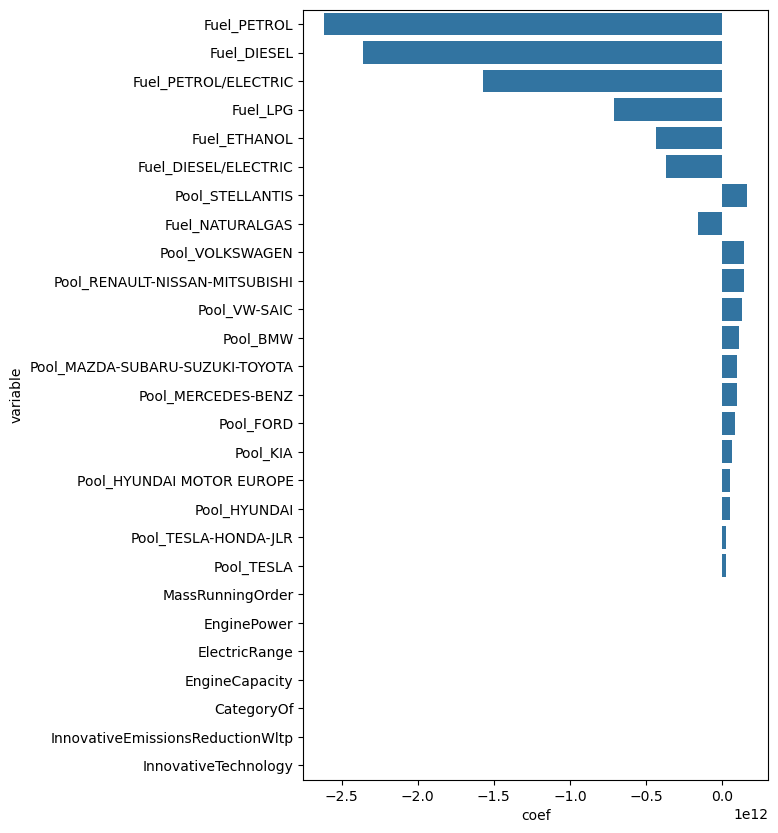

In [68]:
# Tableau des coefficients par variables: 
# Pour des variables normalisées

# calcul des coefs
features = X_train.columns.tolist()
coefs = lr.coef_.tolist()
coefs_va = [abs(valeur) for valeur in coefs]

# Creation et Affichage du df resultats
feature_coef = pd.DataFrame({'coef_va': coefs_va, 'coef': coefs}, index=features).sort_values(by = 'coef_va', ascending = False)
feature_table = feature_coef
print("table des coef")
display(feature_table.round(2).head(30))
print("ordonnée a l'origine", lr.intercept_)

# barplot
dft=feature_coef.reset_index(names='variable')
plt.figure(figsize=(6,10))
sns.barplot(y='variable', x='coef', data = dft, orient = 'h')

##### Analyse (perso): 
Influence gde du nombre de voitures traités. Fule/Electric est à -19, alors que Diesel/Electric est à -6. L'impact réel absolu est le meme, mais il y a beaucoup plus de Diesel.     
Donc cette feature importance nous dit bien qu'une feature a beaucoup d'impact en f(impact0, proportion du feature) cad f(impact0, Dataset) . Mais pas dans l'impact0 absolu sur une voiture f(voiture).    

In [126]:
# Tableau des coefficients par variables: v2
# Sous forme de fonction qui reprend toute la reg_lin à partir de df_preprocessed
# Pour comparer les methodes de normalisation

# Testons 3 methodes: 
#   scaler = preprocessing.StandardScaler()
#   scaler = preprocessing.MinMaxScaler()
#   scaler = None

def lr_coef(df, scaler = 'identity_scaler') :
    """ 
    Affiche les coefficients de la regression lineaire
    Pour comparer les methodes de normalisation
    Avec reprise à partir du df_preprocessed
    parametre optionnel :
        - scaler : preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), ou autre scaler valide. (par défaut : 'identity_scaler' = pas de normalisation) 
    return : 
        - feature_table, lr.intercept_ 
    """

    # Separate variables from target and Select the variables from to work with
    y = df['Co2']
    X = df.drop(['Co2', 'Co2Grade', 'FuelConsumption'], axis=1)

    # Separating into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)

    # Standarization
    identity_scaler = preprocessing.StandardScaler(with_mean=False, with_std=False)
    if scaler == 'identity_scaler' :
        print('attention, X non normalisé')
        scaler = identity_scaler
    try :
        X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
        X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
    except AttributeError as err:
        print(f"{err=}")	# err=AttributeError("'str' object has no attribute 'fit_transform'")
        print(f"{scaler} is not a valid scaler")
        raise   # Possible sans raise d'informer et parametrer "pas de scaling" et continuer

    # model configuration ant training
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # train and test predict
    pred = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    # calcul des coefs
    features = X_train.columns.tolist()
    coefs = lr.coef_.tolist()
    coefs_va = [abs(valeur) for valeur in coefs]

    # Creation et Affichage du df resultats
    feature_coef = pd.DataFrame({'coef_va': coefs_va, 'coef': coefs}, index=features).sort_values(by = 'coef_va', ascending = False)
    feature_table = feature_coef
    print("scaling des features avec: ", scaler)
    print("table des coef")
    print()
    print("scaling des features avec: ", scaler)
    display(feature_table.round(2).head(10))
    print("ordonnée a l'origine", lr.intercept_)

    # barplot
    dft=feature_coef.reset_index(names='variable').head(10)
    plt.figure(figsize=(6,10))
    sns.barplot(y='variable', x='coef', data = dft, orient = 'h')

    return feature_table, lr.intercept_

# TODO: PLutot une classe avec une méthode "affiche"
# ou deux fonctions calcule/affiche



scaling des features avec:  StandardScaler()
table des coef

scaling des features avec:  StandardScaler()


,coef_va,coef
Fuel_PETROL,2.612792e+12,-2.612792e+12
Fuel_DIESEL,2.359587e+12,-2.359587e+12
Fuel_PETROL/ELECTRIC,1.569378e+12,-1.569378e+12
Fuel_LPG,7.082292e+11,-7.082292e+11
Fuel_ETHANOL,4.350678e+11,-4.350678e+11
Fuel_DIESEL/ELECTRIC,3.655686e+11,-3.655686e+11
Pool_STELLANTIS,1.645345e+11,1.645345e+11
Fuel_NATURALGAS,1.594038e+11,-1.594038e+11
Pool_VOLKSWAGEN,1.457453e+11,1.457453e+11
Pool_RENAULT-NISSAN-MITSUBISHI,1.421453e+11,1.421453e+11


ordonnée a l'origine 128.9307288189092


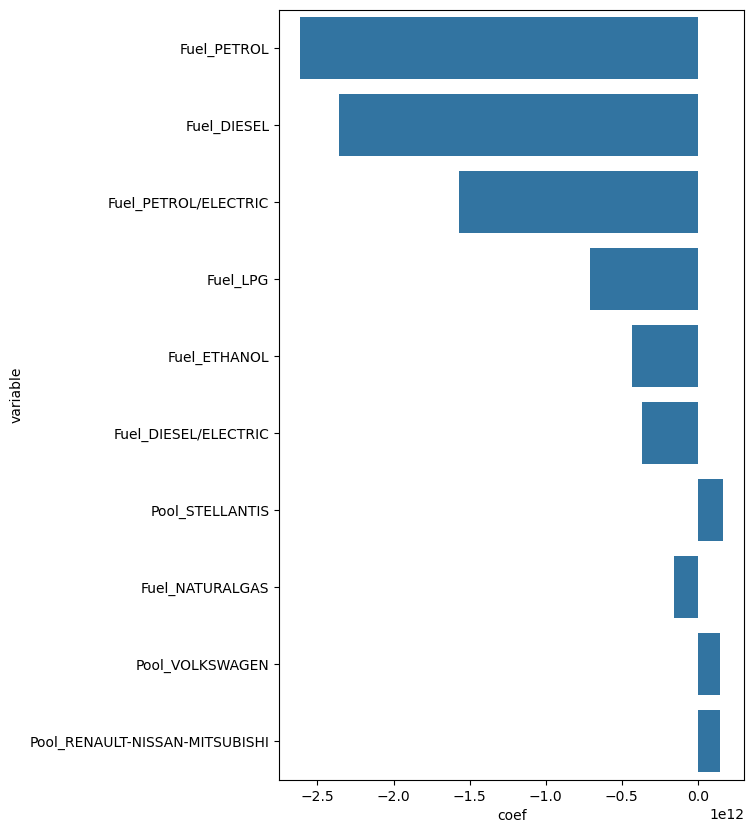

In [132]:
# Tableau des coefficients par variables: v2 - suite 1
# Pour comparer les methodes de normalisation
# Avec reprise à partir de df_preprocessed

# Testons 3 methodes: 
scaler = preprocessing.StandardScaler()
#   scaler = preprocessing.MinMaxScaler()
#   scaler = None

lr_coef(df, scaler = scaler);


scaling des features avec:  MinMaxScaler()
table des coef

scaling des features avec:  MinMaxScaler()


,coef_va,coef
Fuel_DIESEL/ELECTRIC,1.413121e+12,-1.413121e+12
Fuel_PETROL/ELECTRIC,1.413121e+12,-1.413121e+12
Fuel_NATURALGAS,1.413121e+12,-1.413121e+12
Fuel_DIESEL,1.413121e+12,-1.413121e+12
Fuel_ETHANOL,1.413121e+12,-1.413121e+12
Fuel_LPG,1.413121e+12,-1.413121e+12
Fuel_PETROL,1.413121e+12,-1.413121e+12
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,5.744366e+11,-5.744366e+11
Pool_BMW,5.744366e+11,-5.744366e+11
Pool_TESLA-HONDA-JLR,5.744366e+11,-5.744366e+11


ordonnée a l'origine 1987557442121.615


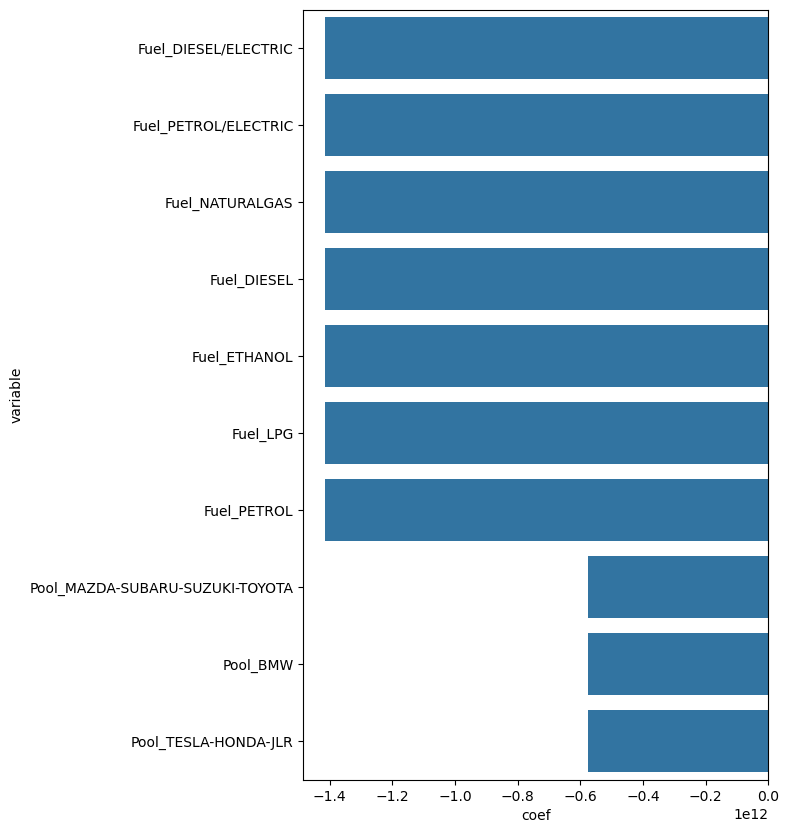

In [133]:
# Tableau des coefficients par variables: v2 - suite 2
# Pour comparer les methodes de normalisation
# Avec reprise à partir de df_preprocessed

# Testons 3 methodes: 
# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
#   scaler = None

lr_coef(df, scaler = scaler);



attention, X non normalisé
scaling des features avec:  StandardScaler(with_mean=False, with_std=False)
table des coef

scaling des features avec:  StandardScaler(with_mean=False, with_std=False)


,coef_va,coef
Fuel_DIESEL/ELECTRIC,82.09,-82.09
Fuel_PETROL/ELECTRIC,54.90,-54.90
Fuel_PETROL,38.89,38.89
Fuel_LPG,31.06,31.06
Fuel_ETHANOL,29.08,29.08
Fuel_DIESEL,27.11,27.11
Fuel_NATURALGAS,10.85,10.85
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,8.20,-8.20
Pool_BMW,7.67,-7.67
Pool_VW-SAIC,6.03,6.03


ordonnée a l'origine 2.8623408277790077


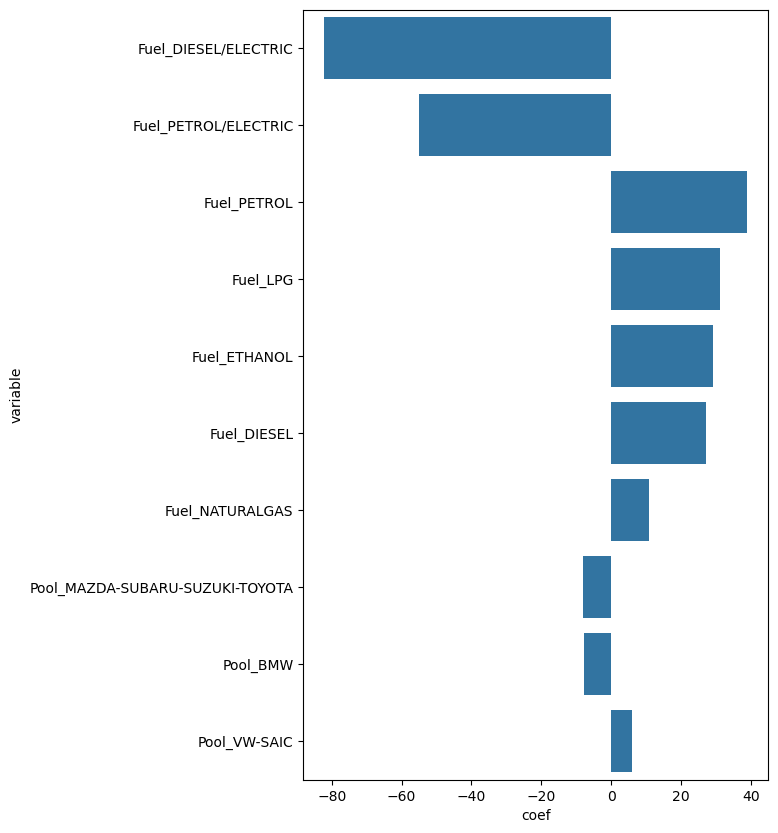

In [134]:
# Tableau des coefficients par variables: v2 - suite 3
# Pour comparer les methodes de normalisation
# Avec reprise à partir de df_preprocessed

# Testons 3 methodes: 
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# scaler = None

lr_coef(df);

# Modele 1: Regression Lineaire - v2  

Version en Test a finaliser ?  

Attention. Meme modèle que precedement, mais avec le code organisé en fonctions  
Avec calul du "Tableau des facteurs d'inflation de la variance (VIF)" pour tester les codépendances trop fortes (pas probant), et le coef de noramlité jarquebaquera     
A Ranger a la fin

In [124]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Standardisation copiée - peu utile 
# def standardisation_lr(data, target):
#     # Séparation du jeu de données en un jeu d'entrainement et de test:
#     X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 123, test_size = 0.2)
    
#     #Standardisation des valeurs numériques + variables 'Marque' (beaucoup de catégories (>10)):
#     cols = ['puiss_max', 'masse_ordma_min', 'Marque']
#     sc = StandardScaler()
#     X_train[cols] = sc.fit_transform(X_train[cols])
#     X_test[cols] = sc.transform(X_test[cols])
    
#     display(X_train.head())
#     display(X_train.describe())
    
#     return [X_train, X_test, y_train, y_test]

In [125]:
# reg_lin copiée - peu utile 
def regression_lineaire(X_train, y_train, X_test, y_test):
    # Instanciation d'un modèle de régression linéaire
    lr = LinearRegression()
    
    # Entraînement et prédictions:
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train) # = valeurs ajustées X_train
    pred_test = lr.predict(X_test) # = valeurs ajustées X_test
    
    return [lr, pred_train, pred_test]

In [126]:
lr, pred_train, pred_test = regression_lineaire(X_train, y_train, X_test, y_test)

In [128]:
from scipy.stats import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.model_selection import cross_val_score

def mean_absolute_percent_error(y,y_pred):
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mape

def indicateurs_lr(lr, X_train, y_train, X_test, y_test, pred_train, pred_test):
    # Affichage des metrics:
    print("R2 modèle_train =", round(lr.score(X_train, y_train),2))
    print("R2 obtenu par CV =", round(cross_val_score(lr,X_train,y_train, cv = 5).mean(),2))
    print("R2 modèle_test =", round(lr.score(X_test, y_test),2))
    print('\nRMSE_train =', round(np.sqrt(mean_squared_error(y_train, pred_train)),2))
    print('RMSE_test =', round(np.sqrt(mean_squared_error(y_test, pred_test)),2))
    print("\nMAE_train:", round(mean_absolute_error(y_train, pred_train),2))
    print("MAE_test:", round(mean_absolute_error(y_test, pred_test),2))
    # Remplecer par MAPE
    print("\nMAPE_test =", round(mean_absolute_percent_error(y_test, pred_test),2), '%')
    
    # Représentation des coefficients:
    coef = lr.coef_
    plt.bar(X_train.columns, coef)
    plt.xticks(X_train.columns, rotation = 90)
    plt.title('\nReprésentation des coefficients de chaque variable du modèle');
    
    # Affichage de l'intercept:
    print('\nIntercept =', round(lr.intercept_,2))    
        
    #Normalité des résidus:
    ## Calcul des résidus et résidus normalisés:
    residus = pred_train - y_train 
    residus_norm = (residus-residus.mean())/residus.std()
    residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1))
    x, pval = jarque_bera(residus_std)
    print('\n Test de normalité de Jarque-Bera: p_value =', round(pval,2)) 
        
    # Tableau des coefficients et des VIF (Multicolinéarité) par variables:
    table = pd.DataFrame({'coefficient': list(lr.coef_)}, index=list(X_train.columns))
    
    # Calcul des vif et stockage dans la colonne 'VIF' de table:
    table['VIF'] = [round(variance_inflation_factor(X_train.values, i),2) for i in range(X_train.shape[1])]
    
    # Classement descendant des coefficients VIT de la regression en valeur absolue
    table.sort_values(by = 'coefficient', ascending = False, key = abs)
    display("Tableau des facteurs d'inflation de la variance (VIF)", table)

    # # Classement descendant des coefficients en valeur absolue
    # table.sort_values(by = 'coefficient', ascending = False, key = abs)
    # display("Tableau des facteurs d'inflation de la variance (VIF)", table)
     
    return [residus, residus_norm, residus_std]
    

In [ ]:
# Calcul des métrics, affichage des indicateurs: 
residus, residus_norm, residus_std = indicateurs_lr(lr1,
                                                    X_train, y_train, X_test, y_test,
                                                    pred_train, pred_test)

In [28]:
def indicateurs_lr_graph(lr, X_train, y_train, X_test, y_test, pred_train, pred_test):

    residus = pred_train - y_train 
    residus_norm = (residus-residus.mean())/residus.std()
    residus_std = residus/np.sqrt(sum(residus**2)/(len(residus)-1))

    # Graphes :
    plt.figure(figsize = (15,10))
    # Espacement des graphes:
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.2,
                        hspace=0.4)
    
    ## Graphe normalisation résidus:
    plt.subplot(2,2,1)
    stats.probplot(residus_norm, plot = plt)
    
    ## Graphe résidus en fonction de pred_train (valeurs ajustées):
    plt.subplot(2,2,2)
    plt.scatter(pred_train, residus)
    plt.plot((pred_train.min(), pred_train.max()), (0, 0), lw=3, color='red')
    plt.plot((pred_train.min(), pred_train.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '± 2 σ') 
    plt.plot((pred_train.min(), pred_train.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '± 3 σ')
    plt.plot((pred_train.min(), pred_train.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
    plt.plot((pred_train.min(), pred_train.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
    plt.title('Résidus en fonction de pred_train (valeurs ajustées)')
    plt.xlabel('pred_train (valeurs ajustées)')
    plt.ylabel('Résidus')
    plt.legend()
    
    ## Graphe boxplot des résidus:
    plt.subplot(2,2,3)
    sns.boxplot(residus)
    plt.title('Boite à moustache des résidus')
    plt.xlabel('résidus')
    
    ## Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
    plt.subplot(2,2,4)
    plt.scatter(pred_test, y_test)
    plt.title('Nuage de points entre pred_test et y_test')
    plt.xlabel('pred_test')
    plt.ylabel('y_test')
    plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red');
    
    return [residus, residus_norm, residus_std]

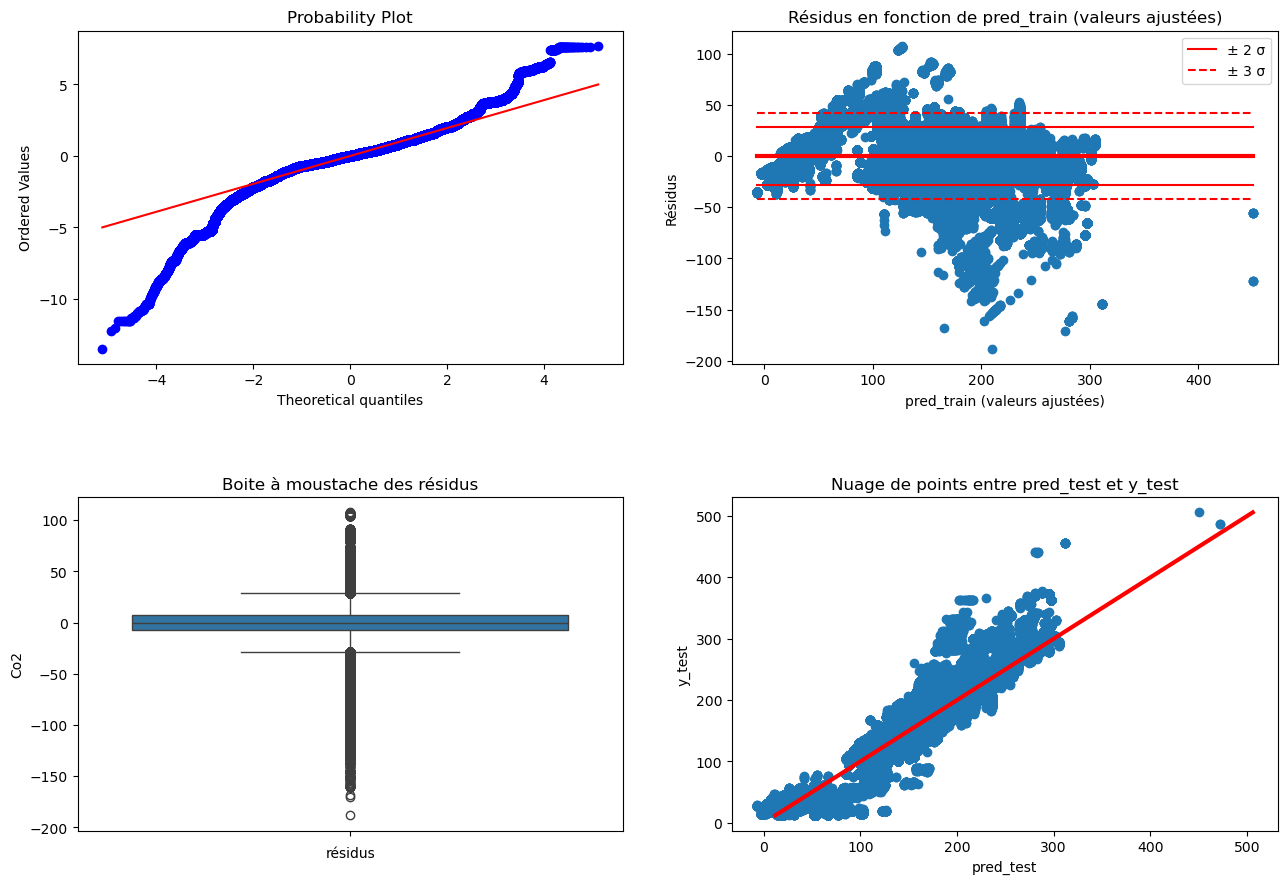

In [47]:
# Calcul des métrics, affichage des indicateurs: 
residus, residus_norm, residus_std = indicateurs_lr_graph(lr,
                                                    X_train, y_train, X_test, y_test,
                                                    pred_train, pred_test)

# Modele 2: Regression Lineaire Régularisée - Elastic_Net

## Préparation des données
-> Identique LinearRegression (même cellules)

## Model training and Scoring

In [18]:
# model configuration ant training - v1
# Avec grille complète

# ATTENTION: Trop de parametres..ne finit pas toujours (convergence)
# A tester en local ou en augmentant le nombre d'itération.
# Faire plutot tourner la cellule suivante avec des grilles réduites,
# quite à la faire plusieurs fois en ajustant les parametres a chaque fois


temps_debut = time.time()

# Gridsearch parameters
l1_ratio=[0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99]
alphas=[0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0]
max_iter= 1000

# lr_en training
lr_en = ElasticNetCV(cv=5, l1_ratio=l1_ratio, alphas=alphas, n_jobs=-1, max_iter= max_iter)
lr_en.fit(X_train, y_train)

# print best parameters
print('best_alpha', lr_en.alpha_, "    parmis ",alphas)
print('best_l1_ratio', lr_en.l1_ratio_, "    parmis ",l1_ratio)
print("nb iteration: ", lr_en.n_iter_)

# predictions 
pred_train = lr_en.predict(X_train)
pred_test = lr_en.predict(X_test)

# SCORING rapide
print('model_score_train :',lr_en.score(X_train, y_train))
print('model_score_test :',lr_en.score(X_test, y_test))

# processing time 
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")


c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7843961.13900876, tolerance: 646943.6651476797
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7879009.637820721, tolerance: 646644.5793514334
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8065898.828900695, tolerance: 646530.004629337
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_mo

Le code a pris 433.26062297821045 secondes pour s'exécuter.


c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.033e+06, tolerance: 8.083e+05
  model = cd_fast.enet_coordinate_descent(


In [9]:
# model configuration ant training - v2
# Avec grille plus petite

temps_debut = time.time()

# Gridsearch parameters
l1_ratio=[0.05, 0.2, 0.4, 0.7, 1]
alphas=[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
max_iter= 5000

# lr_en training
lr_en = ElasticNetCV(cv=5, l1_ratio=l1_ratio, alphas=alphas, n_jobs=-1, max_iter= max_iter)
lr_en.fit(X_train, y_train)

# print best parameters
print('best_alpha', lr_en.alpha_, "    parmis ",alphas)
print('best_l1_ratio', lr_en.l1_ratio_, "    parmis ",l1_ratio)
print("nb iteration: ", lr_en.n_iter_)

# predictions 
pred_train = lr_en.predict(X_train)
pred_test = lr_en.predict(X_test)

# SCORING rapide
print('model_score_train :',lr_en.score(X_train, y_train))
print('model_score_test :',lr_en.score(X_test, y_test))

# processing time 
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")


# Commentaire:
# le code prends 156s sur Colab_GPU_T4
# R2score = 0.89

# 18/01 Colab_GPU4 reduit10%
# le code prends 15s sur Colab_GPU_T4
# R2score =


Le code a pris 262.1738848686218 secondes pour s'exécuter.


In [138]:
# Scoring rapide

l1_ratio=[0.05, 0.2, 0.4, 0.7, 1]
alphas=[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
max_iter= 5000

# print best parameters
print('best_alpha', lr_en.alpha_, "    parmis ",alphas)
print('best_l1_ratio', lr_en.l1_ratio_, "    parmis ",l1_ratio)
print("nb iteration: ", lr_en.n_iter_)

# predictions 
pred_train = lr_en.predict(X_train)
pred_test = lr_en.predict(X_test)

# SCORING rapide
print('model_score_train :',lr_en.score(X_train, y_train))
print('model_score_test :',lr_en.score(X_test, y_test))

# processing time 
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")

best_alpha 0.0     parmis  [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
best_l1_ratio 1     parmis  [0.05, 0.2, 0.4, 0.7, 1]
model_score_train : 0.8931645233443888
model_score_test : 0.893240540075303
Le code a pris 948.7733585834503 secondes pour s'exécuter.


In [139]:
# model configuration ant training - v3
# Avec grille plus petite
# Idem v2 (pour tests)

temps_debut = time.time()

# Gridsearch
l1_ratio=[1]
alphas=[0.0, 0.1]
max_iter= 1000

# lr_en training
lr_en = ElasticNetCV(cv=5, l1_ratio=l1_ratio, alphas=alphas, n_jobs=-1, max_iter= max_iter)
lr_en.fit(X_train, y_train)

# print best parameters
print('best_alpha', lr_en.alpha_, "    parmis ",alphas)
print('best_l1_ratio', lr_en.l1_ratio_, "    parmis ",l1_ratio)
print("nb iteration: ", lr_en.n_iter_)

# predictions 
pred_train = lr_en.predict(X_train)
pred_test = lr_en.predict(X_test)

# SCORING rapide
print('model_score_train :',lr_en.score(X_train, y_train))
print('model_score_test :',lr_en.score(X_test, y_test))

# processing time 
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")

# Commentaires:

# R2score = 0.89

# le code prends 156s sur Colab_GPU_T4
# le code prends 6 mins en local pour len(grid) = 2
# 18/01 Colab_GPU4 reduit10%
# le code prends 15s sur Colab_GPU_T4

# TODO: supr les warnings


c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345420477.77441025, tolerance: 646921.4487400933
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345414700.16411877, tolerance: 646644.5793514334
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\linear_model\_c

best_alpha 0.0     parmis  [0.0, 0.1]
best_l1_ratio 1     parmis  [1]
model_score_train : 0.8931645233443888
model_score_test : 0.893240540075303
Le code a pris 373.47667026519775 secondes pour s'exécuter.


In [141]:
# SCORING complet sous forme de fonction - Cas d'un modele 'sklearn'

# MAPE (Mean Absolute Percentage Error)
def mean_absolute_percent_error(y,y_pred):
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mape


def aff_scores(model, X_train, y_train, pred_train, X_test, y_test, pred_test ):
    
    print('score R2 train :',r2_score(y_train, pred_train))
    print('score R2 test :',r2_score(y_test, pred_test))

    print("MSE train:", mean_squared_error(y_train, pred_train))
    print("MSE test:", mean_squared_error(y_test, pred_test))

    print("MAE train:", mean_absolute_error(y_train, pred_train))
    print("MAE test:", mean_absolute_error(y_test, pred_test))

    print("MAPE train:", mean_absolute_percent_error(y_train, pred_train))
    print("MAPE test:", mean_absolute_percent_error(y_test,  pred_test)))

    # Score par defaut pour lr_en: r2_score
    print('score_model :',model.score(X_train, y_train))
    print('score_model :',model.score(X_test, y_test))


In [143]:
# SCORING
# avec la fonction aff_scores

aff_scores(lr_en, X_train, y_train, pred_train, X_test, y_test, pred_test )

score R2 train : 0.8931645233443888
score R2 test : 0.893240540075303
MSE train: 195.17112509354195
MSE test: 194.4815893496135
MAE train: 9.981431277810396
MAE test: 9.961998131049114
MAPE train: 10.253717245040004
MAPE test: 10.232495270954702
score_model : 0.8931645233443888
score_model : 0.893240540075303


In [144]:
# Pour résultats detailles sur la "robustesse" par CrossValidation

lr_en.mse_path_

# TODO: A terminer
# Tableau clair et conclusion

pd.DataFrame(lr_en.mse_path_)   # marche pour un couple. Faire pour best param.

,0,1,2,3,4
0,214.455653,213.896775,214.369013,213.607291,212.695421
1,195.730272,195.183977,195.375092,195.171684,194.414847


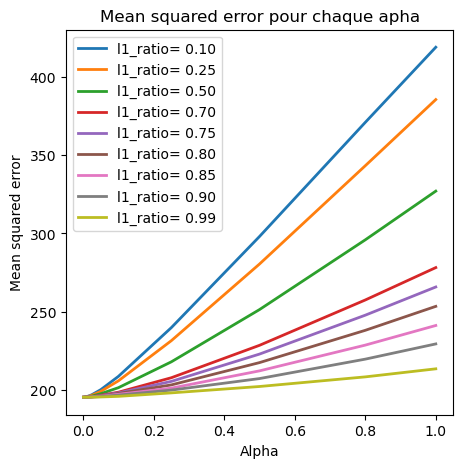

In [27]:
# Graphique du CVgridseach: best parameters
# A faire sur des grilles importantes sur alpha

alphas = lr_en.alphas_
plt.figure(figsize=(5, 5))
for i in range(lr_en.mse_path_.shape[0]) :
    plt.plot(alphas, lr_en.mse_path_[i,:,:].mean(axis=1),
             label='l1_ratio= %.2f' %lr_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque apha')
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# TODO
# facultatif: Ameliorer, virer la bleue ?

### Scores Modele Elastic_Net = Linear Regression

Inutile Elastic_Net.best_parameters ne donne pas de régularisation  
Donc résultats identiques au modèle 1: reg_lin  
Voir scores Modele 1 


In [ ]:
aff_scores(lr_en, X_train, y_train, pred_train, X_test, y_test, pred_test )

In [ ]:
# Résulats modele LinReg

l1=1, alpha = 1, cv=2, tps = 73s
score R2 train : 0.8932092425799827
score R2 test : 0.8931259041860948
MSE train lr: 195.13121354731587
MSE test lr: 212.11769300566738
MAE train lr: 9.979103577561986
MAE test lr: 10.298823076255285

l1=1, alpha = 1, cv=5, tps = 92s
memes résultats

l1=1, alpha = 0.1, cv=5, tps = 163.02174639701843
score R2 train : 0.8929471496240957
score R2 test : 0.8928642567229552
MSE train lr: 195.61011750660973
MSE test lr: 195.04360060335586
MAE train lr: 9.95718154357721
MAE test lr: 9.944969109792327

257.30258798599243

# Modele x : Pistes pour d'autres modeles

Version en Test a finaliser ?  


1) Feature importance + Reduction features
- Temps de calcul en enlevant des features - Inutile car rapide  
- Faire pour trouve une regression "simpliste" et la donner.

2) Regression polynomiale, Stacking, boosting  



In [ ]:
# Colonnes prises en compte:
X_train.columns.tolist()
lr_en.coef_.tolist()

index = X_train.columns.tolist()
serie = pd.Series(lr_en.coef_.tolist(), index=X_train.columns)
serie.sort_values()

# Drop, puis CV

# Modèle XGBoosting – (Extreme Gradient Boosting)

In [43]:
# SCORING complet sous forme de fonction - Cas du XGBoost

# MAPE (Mean Absolute Percentage Error)
def mean_absolute_percent_error(y,y_pred):
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mape

# print scoring
def aff_scores(model, X_train, y_train, pred_train, X_test, y_test, pred_test ):
    
    print('score R2 train :',r2_score(y_train, pred_train))
    print('score R2 test :',r2_score(y_test, pred_test))

    print("MSE train:", mean_squared_error(y_train, pred_train))
    print("MSE test:", mean_squared_error(y_test, pred_test))

    print("MAE train:", mean_absolute_error(y_train, pred_train))
    print("MAE test:", mean_absolute_error(y_test, pred_test))

    print("MAPE train:", mean_absolute_percent_error(y_train, pred_train))
    print("MAPE test:", mean_absolute_percent_error(y_test,  pred_test))

    # Score par defaut pour XGBoost: rmse. parametrable dans XGBoost
    print('best_score_XGB (rmse) :',model.best_score)   # best score = garde la meilleure itération


In [23]:
df.describe()

,CategoryOf,MassRunningOrder,Co2,EngineCapacity,EnginePower,InnovativeTechnology,InnovativeEmissionsReductionWltp,FuelConsumption,ElectricRange,Pool_BMW,Pool_FORD,Pool_HYUNDAI,Pool_HYUNDAI MOTOR EUROPE,Pool_KIA,Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,Pool_MERCEDES-BENZ,Pool_RENAULT-NISSAN-MITSUBISHI,Pool_STELLANTIS,Pool_TESLA,Pool_TESLA-HONDA-JLR,Pool_VOLKSWAGEN,Pool_VW-SAIC,Fuel_DIESEL,Fuel_DIESEL/ELECTRIC,Fuel_ETHANOL,Fuel_LPG,Fuel_NATURALGAS,Fuel_NG,Fuel_PETROL,Fuel_PETROL/ELECTRIC
count,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000,632082.000000
mean,0.043069,1474.319214,128.935669,1571.856934,108.065216,0.744601,1.140594,5.632055,6.107065,0.086388,0.044409,0.016452,0.017650,0.029529,0.069268,0.066427,0.152521,0.222514,0.004987,0.005170,0.161919,0.122767,0.262162,0.004609,0.006488,0.017583,0.000014,0.000892,0.613587,0.094665
std,0.203012,316.727661,42.784588,537.904724,52.475956,0.436086,0.790090,1.742157,18.576067,0.280936,0.206002,0.127206,0.131674,0.169285,0.253909,0.249026,0.359526,0.415935,0.070440,0.071718,0.368377,0.328170,0.439811,0.067730,0.080287,0.131431,0.003773,0.029858,0.486928,0.292752
min,0.000000,915.000000,12.000000,875.000000,44.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1248.000000,118.000000,1199.000000,74.000000,0.000000,0.000000,5.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1422.000000,130.000000,1498.000000,96.000000,1.000000,1.200000,5.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1649.000000,145.000000,1968.000000,118.000000,1.000000,1.900000,6.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,3275.000000,456.000000,6749.000000,574.000000,1.000000,2.900000,20.100000,126.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Separate variables from target and Select the variables from to work with

y = df['Co2']
X = df.drop(['Co2', 'Co2Grade', 'FuelConsumption'], axis=1)

In [147]:
# Preparation des données v1 - train/valid/test

# split X,y to train, valid, test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2)

# DMatrix for XGBoost
train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

# tps de calcul = 10s


In [34]:
# FAC Preparation des données v2 
# Uniquement 2 jeux: train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)


In [ ]:
# Faut il normaliser ?
# Data normalization is not necessary for decision trees. 
# because XGBoost is based on decision trees
# a tester

In [ ]:
# XGB training
# Parametres "rapides" 
# ->  'learning_rate' : 1, num_boost_round = de 100(pour test code) à 500.

temps_debut = time.time()

params = {'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 100, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

# preds = model.predict(test)
pred_test = model.predict(test)
pred_train = model.predict(train)

# fit time
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")


# Commentaire:
# le code prends 120s sur Colab_CPU
# rmse = 3,05

# 18/01 - FrAl21
# le code prends 160s sur Colab_CPU
# rmse = 2,75


In [151]:
# SCORING
# avec la fonction aff_scores

# predictions 
pred_test = model.predict(test)
pred_train = model.predict(train)

# scores
aff_scores(model, X_train, y_train, pred_train, X_test, y_test, pred_test )


score R2 train : 0.9957329573991971
score R2 test : 0.9957254491119126
MSE train: 7.7829247
MSE test: 7.821422
MAE train: 1.794348
MAE test: 1.7999539
MAPE train: 1.4987505972385406
MAPE test: 1.5014722011983395
best_score_XGB (rmse) : 2.796680674042551


In [ ]:
# Pour test de parametres
# XGB training + Scoring rapide

# > 'learning_rate' : 0->1, 'num_boost_round' :100(pour test code) -> 5000,  'colsample_bytree',  'max_depth', 'early_stopping_round'
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

temps_debut = time.time()

# model training
params = {'booster' : 'gbtree', 'colsample_bytree' : 1, 'learning_rate' : 0.5, 'max_depth' : 8, 'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 1000, early_stopping_rounds = 20, evals= [(train, 'train'), (test, 'valid')] )

# predictions 
pred_test = model.predict(test)
pred_train = model.predict(train)

# SCORING rapide
print('score R2 train :',r2_score(y_train, pred_train))
print('score R2 test :',r2_score(y_test, pred_test))
# Score par defaut pour XGBoost: rmse. parametrable dans XGBoost
print('best_score_XGB (rmse) :',model.best_score)   # best score = garde la meilleure itération

# processing time 
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")

# Commentaire:
# le code prends 130s sur Colab_CPU, 5mn en local
# rmse = 3,05
# reg:linear
# Memes scores sur un autre train_split (2,82)


**-> Historique des test sur excel**


In [193]:
# A revoir
# CrossValidation evaluation
# Pour avoir un CVscore et des std, car cela retourne un df et pas un clf

from xgboost import cv
params = {'booster' : 'gbtree', 'objective' : 'reg:squarederror' ,'learning_rate': 1}
xgb_cv = cv(dtrain=train, params=params, nfold=3,
                    num_boost_round=500, early_stopping_rounds=20, metrics="rmse", as_pandas=True)

In [194]:
xgb_cv

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.717092,0.009262,10.717100,0.005567
1,9.022555,0.050934,9.022603,0.033376
2,8.683187,0.005317,8.684920,0.019072
3,8.119984,0.063613,8.120683,0.051212
4,7.659570,0.089732,7.661577,0.104477
...,...,...,...,...
495,2.247280,0.002722,2.275373,0.001609
496,2.247106,0.002826,2.275217,0.001537
497,2.246893,0.002729,2.275047,0.001602
498,2.246726,0.002702,2.274868,0.001586


In [ ]:
evals_result()

In [18]:
%pwd

'/content/gdrive/MyDrive/ROOT'

In [153]:
# Gestion des sauvegardes des modeles XGBoost

import joblib

model1 = 'xgb2501.joblib'   # best model with 'learning_rate' : 0.5,  'iter' : 1 000

# joblib.dump(model, './Dataset/xgb2501.joblib')		#Sauvegarde joblib 856ko pour FrAl21
model = joblib.load('./Dataset/xgb2501.joblib')		    #Lecture


In [154]:
# SCORING
# avec la fonction aff_scores

# predictions 
pred_test = model.predict(test)
pred_train = model.predict(train)

# scores
aff_scores(model, X_train, y_train, pred_train, X_test, y_test, pred_test )

score R2 train : 0.9972022500115031
score R2 test : 0.9972099689914267
MSE train: 5.1029873
MSE test: 5.1051016
MAE train: 1.4148513
MAE test: 1.4167993
MAPE train: 1.1640789918601513
MAPE test: 1.164527516812086
best_score_XGB (rmse) : 2.2709041085853734


In [191]:
# Tableau de resultats. Exemples
# Valeurs réelle / Valeurs prédites / residus / residus en %

results = pd.DataFrame({'Co2_reel': y_test, 'Co2_pred': pred_test, 'residus': y_test-pred_test,'residus_percent': (y_test-pred_test)/y_test*100 }, index=X_test.index)
results = results.round(1).sort_values(by='Co2_reel')
results.sample(15).sort_values(by='Co2_reel')

,Co2_reel,Co2_pred,residus,residus_percent
6543862,21.0,20.500000,0.5,2.3
6577158,22.0,23.700001,-1.7,-7.7
1528164,111.0,112.400002,-1.4,-1.3
63411,117.0,117.000000,-0.0,-0.0
7493155,118.0,118.199997,-0.2,-0.2
722037,119.0,118.699997,0.3,0.3
2597070,124.0,122.500000,1.5,1.2
7634598,124.0,119.800003,4.2,3.4
4817126,135.0,132.600006,2.4,1.8
2194053,135.0,129.000000,6.0,4.4


In [ ]:
# RECHERCHE sur "Tableau de resultats. Exemples"

# results = Valeurs réelle / Valeurs prédites / residus / residus en %. Exemples
# Etrange, la colonne Co2_pred garde trop de décimales -> Recherche cellule suivante

results = pd.DataFrame({'Co2_reel': y_test, 'Co2_pred': pred_test, 'residus': y_test-pred_test,'residus_percent': (y_test-pred_test)/y_test*100 }, index=X_test.index)
results = results.round(1).sort_values(by='Co2_reel')
results.sample(15).sort_values(by='Co2_reel')

# testé beaucoup de config... pas de solution !!
# pred_test.round(2) #-> array([118.47,  35.62, 186.  , ..., 109.36, 127.36,  26.52], dtype=float32)
# pred_test.round(2).tolist() # -> [118.47000122070312, 35.619998931...]
# list(pred_test.round(2))   # -> [118.47, 35.62,...]


Text(0, 0.5, 'Co2_prédit')

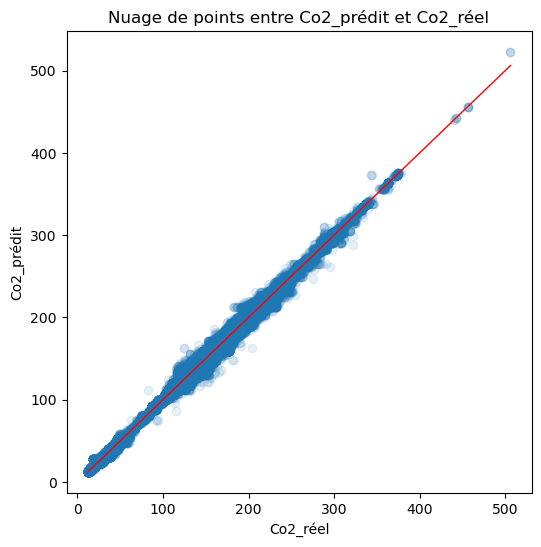

In [156]:
# Etude des résidus et valeurs abberantes

plt.figure(figsize=(6,6))
plt.scatter( results.Co2_reel, results.Co2_pred, alpha = 0.1)
plt.plot((results.Co2_reel.min(), results.Co2_reel.max()), (results.Co2_reel.min(), results.Co2_reel.max()), lw = 1, color ='red');
plt.title('Nuage de points entre Co2_prédit et Co2_réel')
plt.xlabel('Co2_réel')
plt.ylabel('Co2_prédit')

Text(0, 0.5, 'Co2_réel')

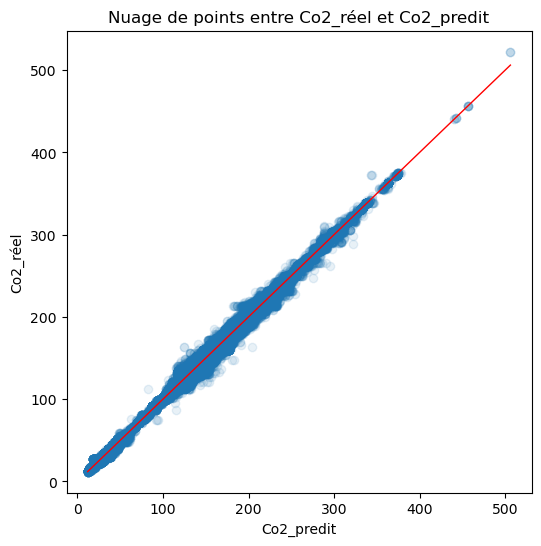

In [157]:
# Etude des résidus et valeurs abberantes
# Avec inversion des axes x/y

plt.figure(figsize=(6,6))
plt.scatter( results.Co2_reel, results.Co2_pred, alpha = 0.1)
plt.plot((results.Co2_reel.min(), results.Co2_reel.max()), (results.Co2_reel.min(), results.Co2_reel.max()), lw = 1, color ='red');
plt.title('Nuage de points entre Co2_réel et Co2_predit')
plt.xlabel('Co2_predit')
plt.ylabel('Co2_réel')

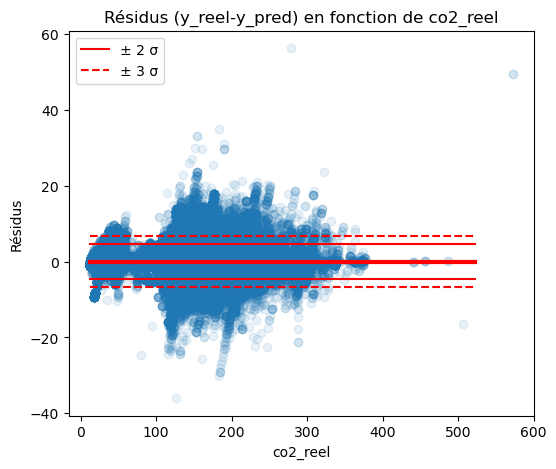

In [45]:
## Graphe résidus en fonction de pred_train (valeurs ajustées):

residus = results.residus

plt.figure(figsize=(6,5))
plt.scatter(results.Co2_reel, results.residus, alpha = 0.1)
plt.plot((pred_test.min(), pred_test.max()), (0, 0), lw=3, color='red')
plt.plot((pred_test.min(), pred_test.max()), (2*residus.std(), 2*residus.std()), 'r-', lw=1.5, label = '± 2 σ') 
plt.plot((pred_test.min(), pred_test.max()), (3*residus.std(), 3*residus.std()), 'r--', lw=1.5, label = '± 3 σ')
plt.plot((pred_test.min(), pred_test.max()), (-2*residus.std(), -2*residus.std()), 'r-',lw=1.5)
plt.plot((pred_test.min(), pred_test.max()), (-3*residus.std(), -3*residus.std()), 'r--', lw=1.5)
plt.title('Résidus (y_reel-y_pred) en fonction de co2_reel')
plt.xlabel('co2_reel')
plt.ylabel('Résidus')
plt.legend()
print("2 σ = ",2*residus.std())
print("3 σ = ",3*residus.std())

# TODO: supr "residus = results.residus"

In [50]:
print("2 σ = ",2*residus.std())
print("3 σ = ",3*residus.std())

2 σ =  4.514503002166748
3 σ =  6.771754503250122


c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\preprocessing\_data.py:247: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\ludov\.conda\envs\env_ML\lib\site-packages\sklearn\preprocessing\_data.py:266: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


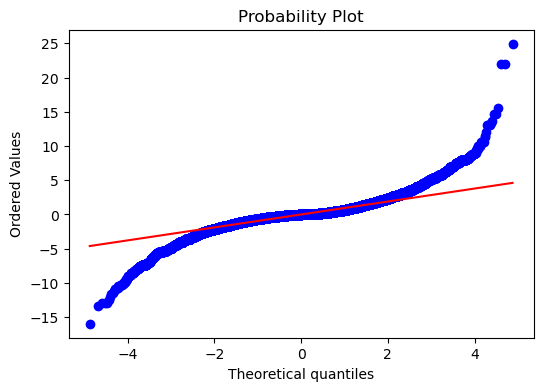

In [51]:
# diagramme Quantile-Quantile ou (Q-Q plot)
# Sur les residus normalises

from scipy import stats

residus_norm = preprocessing.scale(results.residus)
plt.figure(figsize=(6,4))
stats.probplot(residus_norm, plot=plt, dist='norm')
plt.show()

Text(0.5, 0, 'résidus')

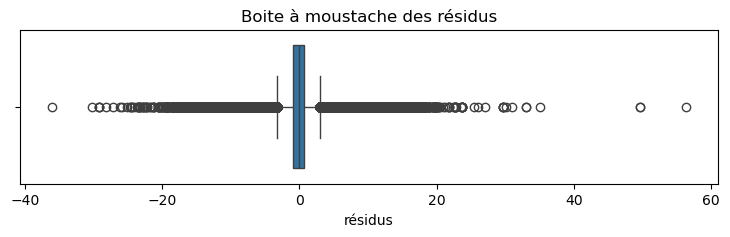

In [53]:
# Boite a moustache

plt.figure(figsize=(9,2))
sns.boxplot(results.residus, orient='h')
plt.title('Boite à moustache des résidus')
plt.xlabel('résidus')

# TODO: Etude des outliers

# Pistes de recherche  
- Optimisation (gridSearch sur les parametres de XGBoost, qui est déja très bon) --> FAIT. 
- Feature importance, interpretabilité (shap) --> FAIT
- Sauvegarder le best_model pour travailler sur differents Nbook --> FAIT

# Interprétabilité du meilleur modèle (XGBoost)

## Feature importance
- Methode xgboost -- > Comment interpréter
- Methode shap Value --> Plus fiable

**Faire sur des modeles reduits si trop long**

### a) Methode XGBoost

In [214]:
# feature importance: methode xgboost

scores_dic = model.get_score(importance_type='weight')
scores_df = pd.DataFrame([scores_dic])
scores_df = df.transpose().rename(columns={0: 'coef'}).sort_values(by='coef', ascending = False)
scores_df

# Rque: For linear model, only “weight” is defined and it’s the normalized coefficients without bias.

,coef
ElectricRange,3.979770e+09
MassRunningOrder,1.806751e+09
EnginePower,1.216040e+09
EngineCapacity,1.643867e+08
Fuel_DIESEL,4.923254e+07
InnovativeEmissionsReductionWltp,3.464258e+07
Pool_BMW,2.303209e+07
Fuel_PETROL,1.782518e+07
CategoryOf,1.160418e+07
Pool_STELLANTIS,1.049991e+07


<Axes: title={'center': 'feature importance (method : weight)'}, xlabel='F score', ylabel='Features'>

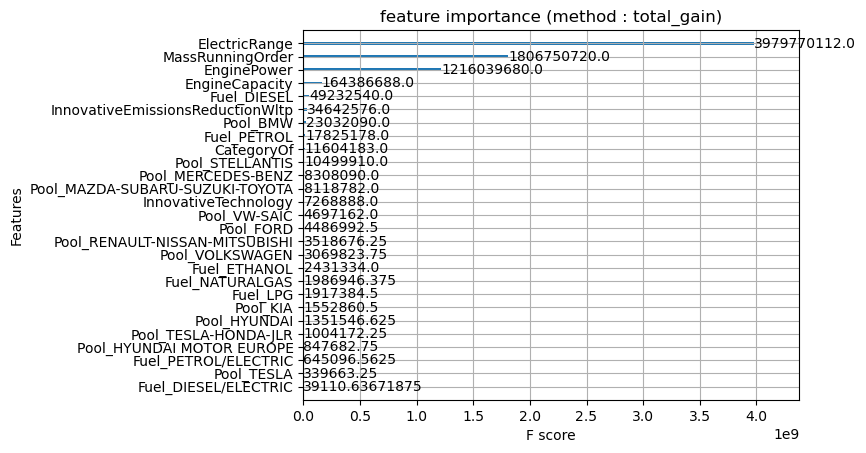

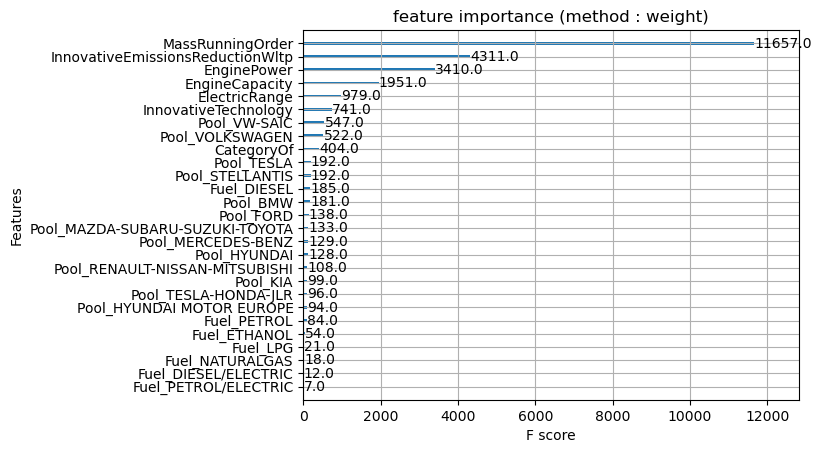

In [248]:

# D'apres doc de get_score, seul weight marcherait. Mais ils marchent tous. 
# donc prendre weight pour avoir memes valeurs que table issu de get_score
# sinon prendre 'total_gain' qui semble ici meilleur

xgb.plot_importance(model, importance_type='total_gain', title="feature importance (method : total_gain)")                  
xgb.plot_importance(model, importance_type='weight', title="feature importance (method : weight)")
# xgb.plot_importance(model, importance_type='gain')   # Nul ici



### b) Methode shap_values

In [ ]:
# Fac: Utile uninquement sur google colab
%pip install shap
%pip install -U Skater

In [49]:
# feature importance: methode shap_values

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)


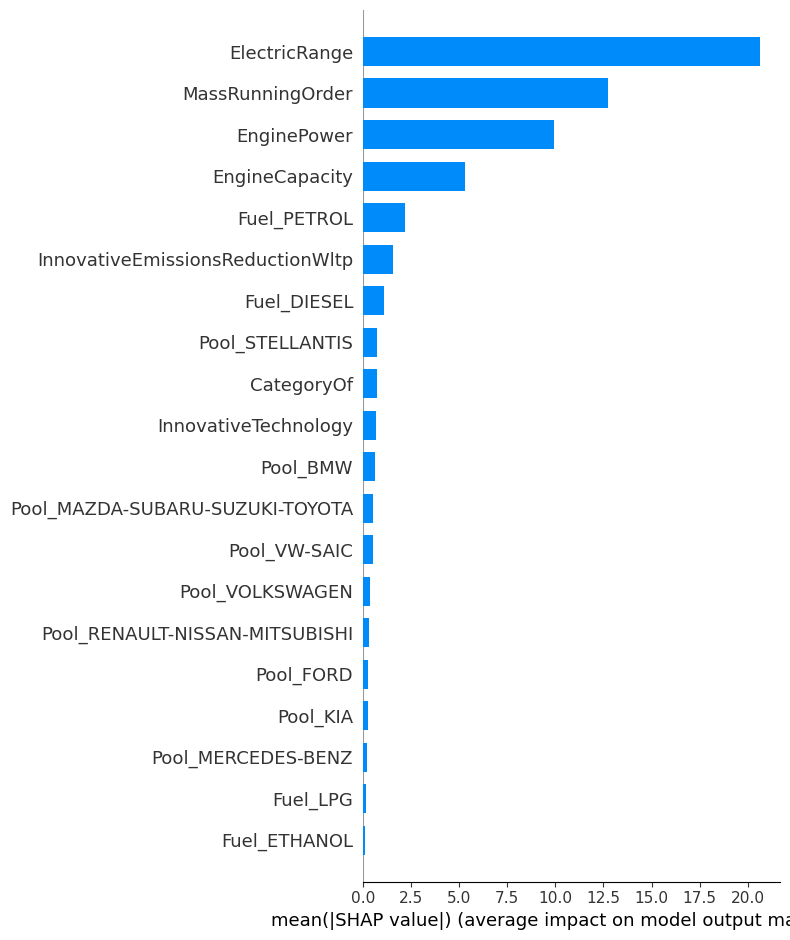

In [ ]:
# feature importance: methode shap_values

shap_graph = shap.summary_plot(shap_values, X_test, plot_type="bar")

# TODO: Trouver le moyen d'ecrire les scores

### b) Methode skater

In [ ]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_train, feature_names=X_train.columns)

def predict_xg(x):
    return pd.DataFrame(model.predict(xgb.DMatrix(x)))

model_1 = InMemoryModel(predict_xg, examples = X_train)

[27/27] features ████████████████████ Time elapsed: 1018 seconds

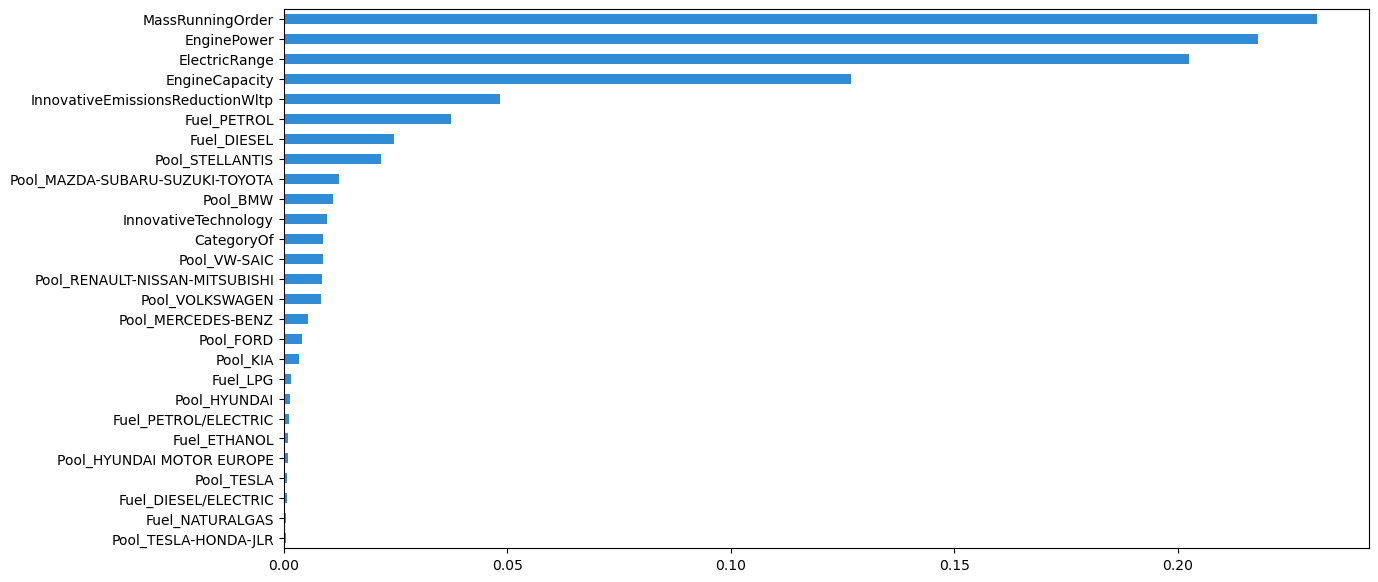

In [ ]:
plots = interpreter.feature_importance.plot_feature_importance(
    model_1, ascending=False)

### d) Autres graphes shap_values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


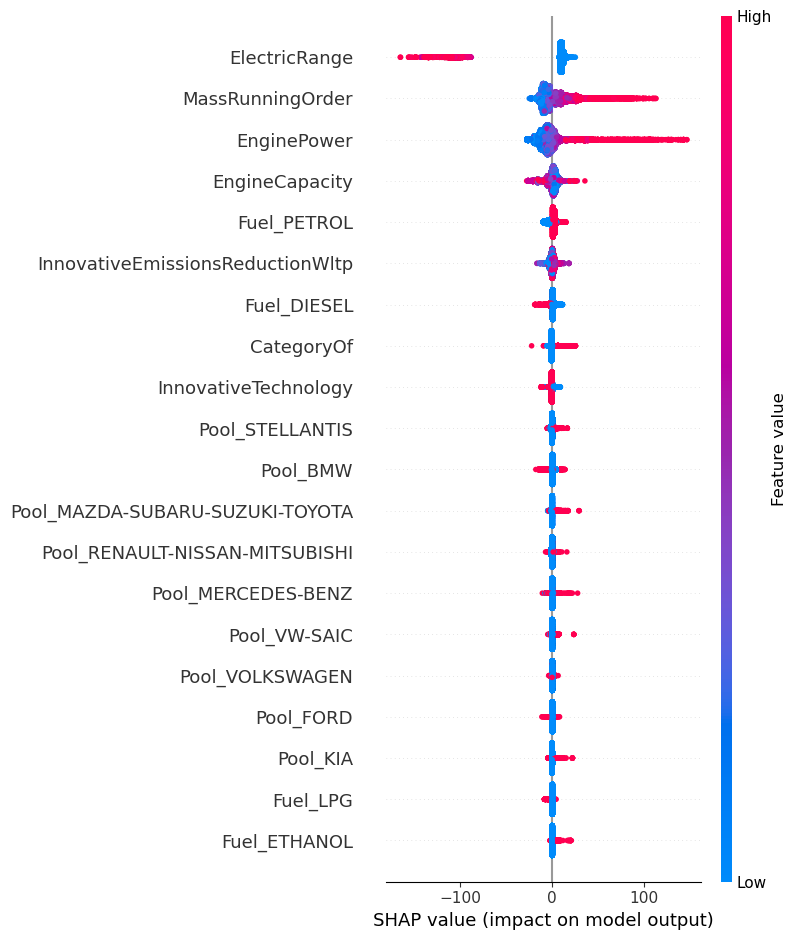

In [ ]:
shap.summary_plot(shap_values, X_test)

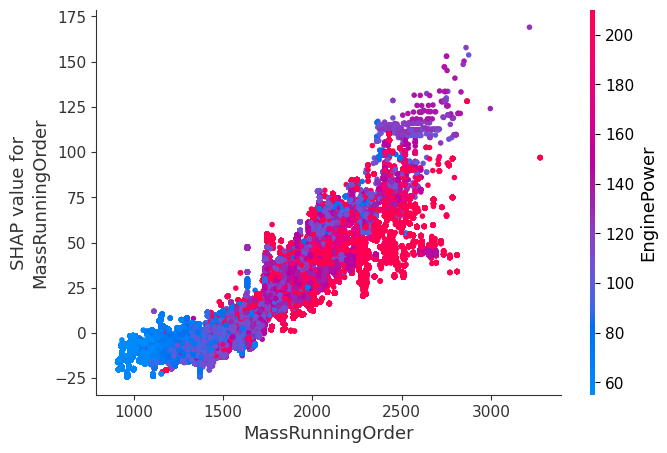

In [ ]:
shap.dependence_plot("MassRunningOrder", shap_values, X_test, interaction_index= "EnginePower")

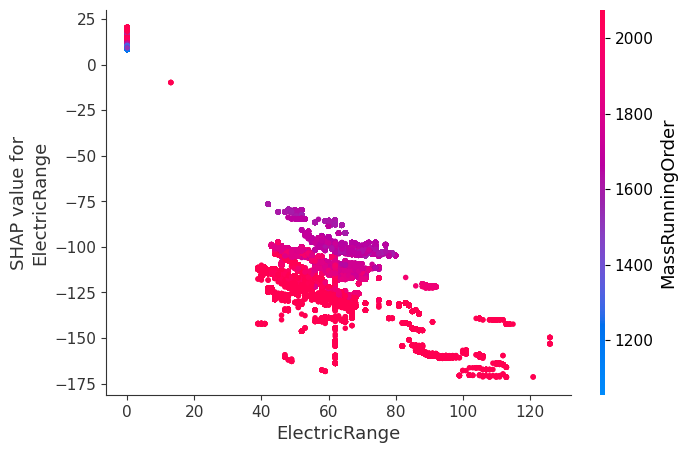

In [ ]:
# Les graphiques de dépendance de SHAP montrent l'effet d'une variable sur l'ensemble des données
shap.dependence_plot("ElectricRange", shap_values, X_test, interaction_index= "MassRunningOrder")

In [14]:
shap.initjs()

In [51]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

## Arbre 0 de XGBoost
-- > Difficile (impossible) à interprétes
-- > A faire sur un XGboost 3 niveau

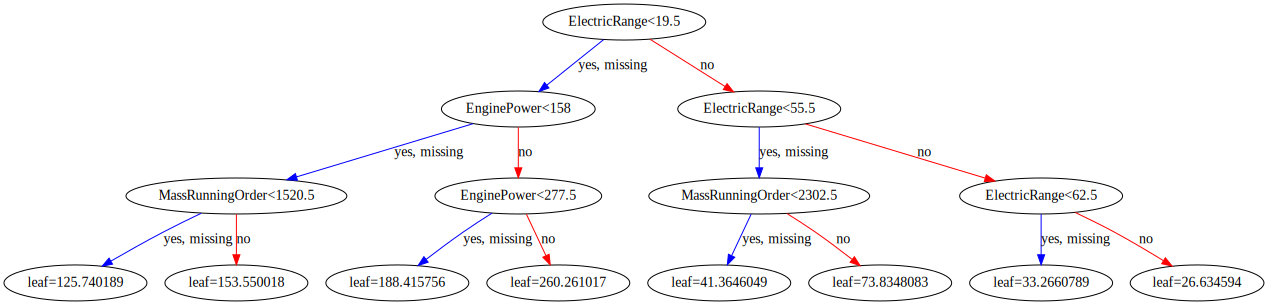

In [61]:
import graphviz
xgb.to_graphviz(model, num_trees=0)

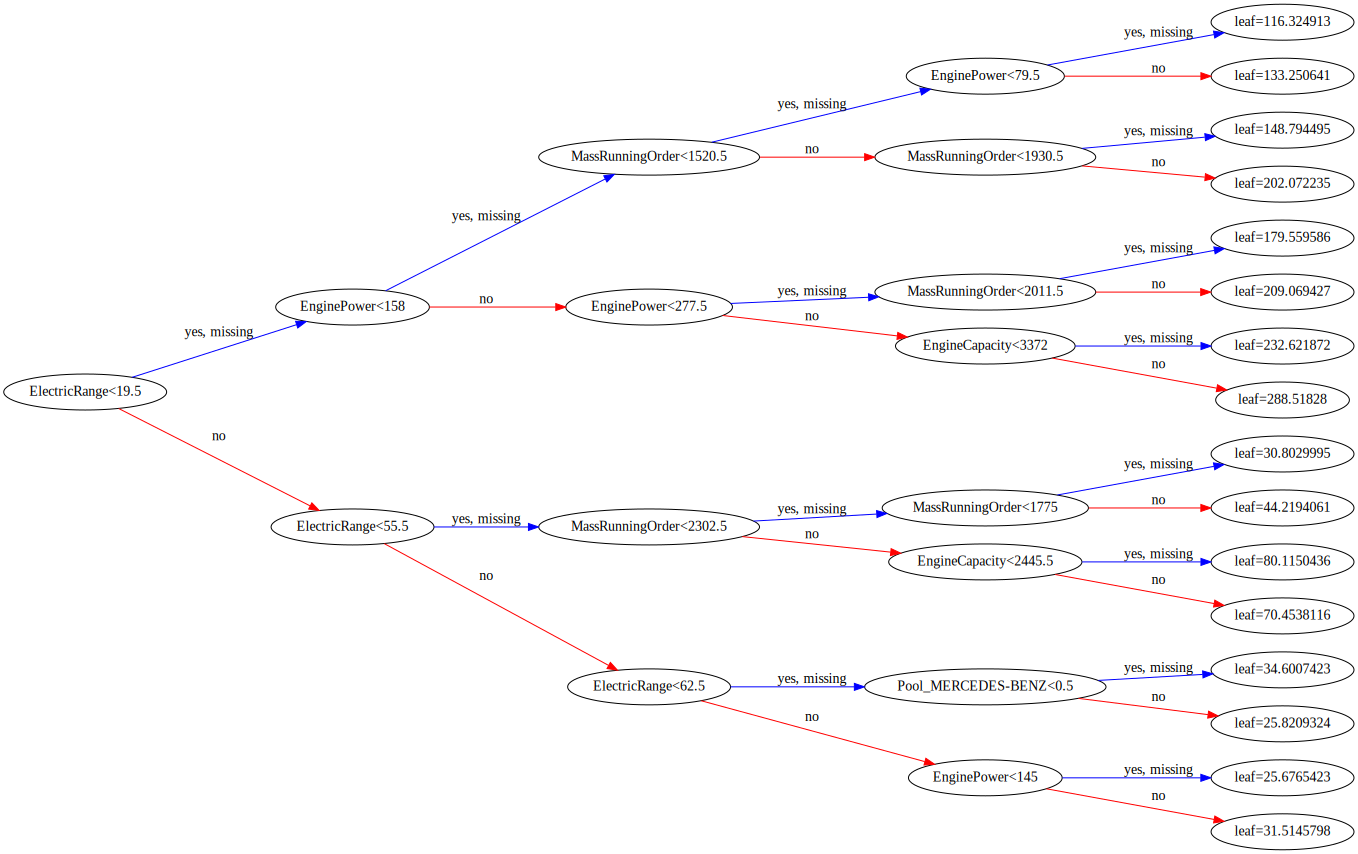

In [65]:
xgb.to_graphviz(model, num_trees=0, rankdir='LR')

# Recherches en cours

In [56]:
# Creation d'un dataset petit 
# Pour tests

df = pd.read_pickle('./Dataset/c02_fr&al_21_v04.pkl')
df = df.sample(100000)



In [47]:
# SCORING complet sous forme de fonction - Cas du XGBoost

# MAPE (Mean Absolute Percentage Error)
def mean_absolute_percent_error(y,y_pred):
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    return mape

# print scoring
def aff_scores(model, X_train, y_train, pred_train, X_test, y_test, pred_test ):
    
    print('score R2 train :',r2_score(y_train, pred_train))
    print('score R2 test :',r2_score(y_test, pred_test))

    print("MSE train:", mean_squared_error(y_train, pred_train))
    print("MSE test:", mean_squared_error(y_test, pred_test))

    print("MAE train:", mean_absolute_error(y_train, pred_train))
    print("MAE test:", mean_absolute_error(y_test, pred_test))

    print("MAPE train:", mean_absolute_percent_error(y_train, pred_train))
    print("MAPE test:", mean_absolute_percent_error(y_test,  pred_test))

    # Score par defaut pour XGBoost: rmse. parametrable dans XGBoost
    print('best_score_XGB (rmse) :',model.best_score)   # best score = garde la meilleure itération

In [64]:
# Construction d'un modèle XGB rapide
# Pour tests

temps_debut = time.time()

# split X,y to train, valid, test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2)

# DMatrix for XGBoost
train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

# XGB training
# Parametres "rapides" 
# ->  'learning_rate' : 1, num_boost_round = de 100(pour test code) à 500.


# model training
params = {'booster' : 'gbtree', 'learning_rate' : 1,  'max_depth' : 4,  'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 300, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )

# predictions 
pred_test = model.predict(test)
pred_train = model.predict(train)

# SCORING rapide
print('score R2 train :',r2_score(y_train, pred_train))
print('score R2 test :',r2_score(y_test, pred_test))
# Score par defaut pour XGBoost: rmse. parametrable dans XGBoost
print('best_score_XGB (rmse) :',model.best_score)   # best score = garde la meilleure itération

# processing time 
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")




[12:53:07] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:13.41619	valid-rmse:13.49578
[1]	train-rmse:11.49112	valid-rmse:11.63222
[2]	train-rmse:10.73668	valid-rmse:10.85288
[3]	train-rmse:9.98812	valid-rmse:10.05227
[4]	train-rmse:9.62842	valid-rmse:9.69552
[5]	train-rmse:9.10810	valid-rmse:9.18683
[6]	train-rmse:8.86722	valid-rmse:8.95092
[7]	train-rmse:8.50383	valid-rmse:8.57297
[8]	train-rmse:8.40715	valid-rmse:8.47679
[9]	train-rmse:8.18938	valid-rmse:8.27752
[10]	train-rmse:7.97286	valid-rmse:8.06588
[11]	train-rmse:7.87165	valid-rmse:7.92969
[12]	train-rmse:7.72092	valid-rmse:7.77256
[13]	train-rmse:7.52539	valid-rmse:7.58045
[14]	train-rmse:7.30650	valid-rmse:7.33867
[15]	train-rmse:7.25485	valid-rmse:7.27866
[16]	train-rmse:7.06424	valid-rmse:7.11429
[17]	train-rmse:6.92392	valid-rmse:6.98218
[18]	train-rmse:6.83824	valid-rmse:6.87986
[19]	train-

In [53]:
# Chargement du best_model
# Pour tests

# Import/Export des modeles XGBoost
import joblib
model_name = 'xgb2501.joblib'   # best model with 'learning_rate' : 0.5,  'iter' : 1 000

model = joblib.load('./Dataset/xgb2501.joblib')		



In [54]:
shap.initjs()

In [39]:
X_sampled = X_train.sample(10000, random_state=10)
y_train.mean()


128.79123

In [55]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

In [351]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

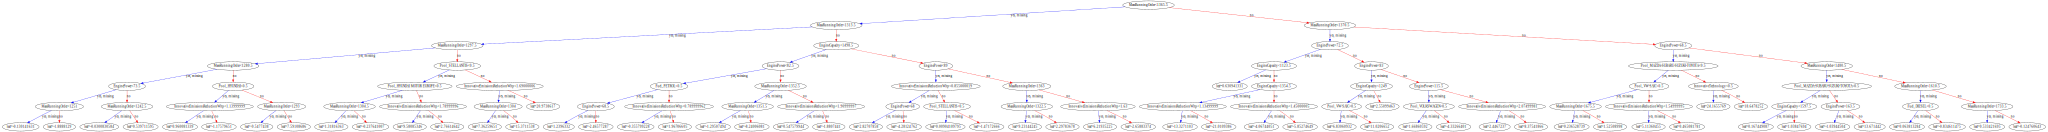

In [ ]:
import graphviz
xgb.to_graphviz(model, num_trees=20)

In [5]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_sampled)

NameError: name 'shap' is not defined

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [ ]:
pred = np.array(pred)
original = np.array(df.loc[indexes_cars_predicted,'MSRP'])

df_cleaned_dummies.loc[indexes_cars_predicted,'MSRP']

def average_gap(l1,l2):
    resu=0
    for i in range(len(l1)):
        resu += np.abs(l1[i]-l2[i])
    resu = resu/len(l1)
    return(resu)

print("Over",len(pred),"cars, the average gap between the predicted price and the real price is",round(average_gap(pred,original),0),"$")

plt.figure(figsize=(15,7))
sns.distplot(pred, color="blue", label="Distrib Predictions", hist = False)
sns.distplot(original, color="red", label="Distrib Original", hist = False)
plt.title("Distribution of pred and original MSRP")
plt.legend()

In [335]:
import xgboost

# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 4, "base_score": 0, "lambda": 0}, Xd, 1)
print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 6001.713
0:[ElectricRange<26] yes=1,no=2,missing=1,gain=197076992,cover=200000
	1:[EnginePower<158] yes=3,no=4,missing=3,gain=70813184,cover=180044
		3:[MassRunningOrder<1520.5] yes=7,no=8,missing=7,gain=23934976,cover=164792
			7:[EnginePower<79.5] yes=15,no=16,missing=15,gain=8764288,cover=123408
				15:leaf=116.849014,cover=54826
				16:leaf=133.809311,cover=68582
			8:[MassRunningOrder<1930.5] yes=17,no=18,missing=17,gain=9738368,cover=41384
				17:leaf=149.22905,cover=37643
				18:leaf=202.725204,cover=3741
		4:[EnginePower<277.5] yes=9,no=10,missing=9,gain=13291136,cover=15252
			9:[MassRunningOrder<2011.5] yes=19,no=20,missing=19,gain=2131360,cover=11941
				19:leaf=180.234055,cover=8387
				20:leaf=209.454422,cover=3554
			10:[EngineCapacity<3372] yes=21,no=22,missing=21,gain=2534560,cover=3311
				21:leaf=233.422729,cover=1689
				22:leaf=288.769409,cover=1622
	2:[ElectricRange<55.5] yes=5,no=6,missing=5,gain=707328,cover=19956
		5:[MassRunningOrder<2302.5] yes=1

In [336]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

3.0517578e-05

In [337]:
shap.plots.beeswarm(explanation)

AttributeError: 'DMatrix' object has no attribute 'shape'

In [324]:
shap.plots.beeswarm(explanation)

AttributeError: 'DMatrix' object has no attribute 'shape'

In [320]:

# model = xgb.train(params=params, dtrain = train, num_boost_round = 100, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )
model = xgb.XGBRegressor()
model.fit(X, y);

In [321]:
# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[:100])

AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'

# Recherche sur les shap_values

In [ ]:
# Fits the explainer
model.predict

<bound method Booster.predict of <xgboost.core.Booster object at 0x0000020F2D2706A0>>

In [ ]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)


In [317]:
model = xgb.train(params=params, dtrain = train, num_boost_round = 100, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )


[08:49:29] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.79745	valid-rmse:10.83231
[1]	train-rmse:9.07427	valid-rmse:9.19381
[2]	train-rmse:8.38556	valid-rmse:8.52755
[3]	train-rmse:7.81304	valid-rmse:7.95949
[4]	train-rmse:7.50073	valid-rmse:7.64651
[5]	train-rmse:7.17714	valid-rmse:7.29923
[6]	train-rmse:6.76383	valid-rmse:6.89534
[7]	train-rmse:6.40428	valid-rmse:6.56736
[8]	train-rmse:6.03566	valid-rmse:6.17898
[9]	train-rmse:5.83894	valid-rmse:5.97925
[10]	train-rmse:5.58102	valid-rmse:5.74753
[11]	train-rmse:5.51737	valid-rmse:5.68869
[12]	train-rmse:5.37038	valid-rmse:5.51458
[13]	train-rmse:5.25452	valid-rmse:5.40673
[14]	train-rmse:5.20466	valid-rmse:5.35251
[15]	train-rmse:5.14940	valid-rmse:5.30255
[16]	train-rmse:5.05267	valid-rmse:5.21829
[17]	train-rmse:4.88766	valid-rmse:5.06159
[18]	train-rmse:4.81804	valid-rmse:4.99049
[19]	train-rmse:

In [ ]:
# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(model.predict_proba, X)
shap_values = explainer(X[:100])

# get just the explanations for the positive class
shap_values = shap_values[..., 1]
Exact explainer: 101it [00:12,  8.13it/s]

In [ ]:
# XGB training
# Parametres "rapides" 
# ->  'learning_rate' : 1, num_boost_round = de 100(pour test code) à 500.

temps_debut = time.time()

params = {'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'reg:linear'}
model2 = xgb.train(params=params, dtrain = train, num_boost_round = 1000, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

# preds = model.predict(test)
pred_test = model2.predict(test)
pred_train = model2.predict(train)

# fit time
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")


# Commentaire:
# le code prends 120s sur Colab_CPU
# rmse = 3,05

# 18/01 - FrAl21
# le code prends 160s sur Colab_CPU
# rmse = 2,75

In [292]:
explainer = shap.Explainer(model2)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


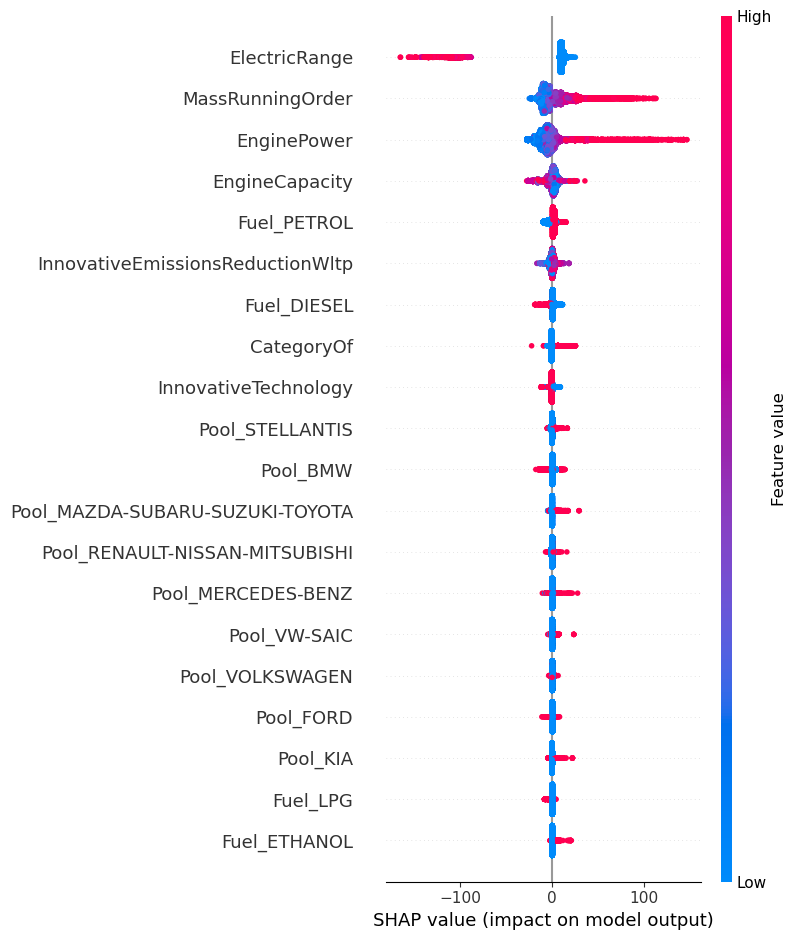

In [293]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [295]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)


IndexError: invalid index to scalar variable.

In [286]:
# Recherche sur les shap_values, avec un dataset petit 2e5
# feature importance: methode shap_values

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)




# Recherche sur les shap_values

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)



TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [287]:

from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

features = X_test.columns
print_feature_importances_shap_values(shap_values, features)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

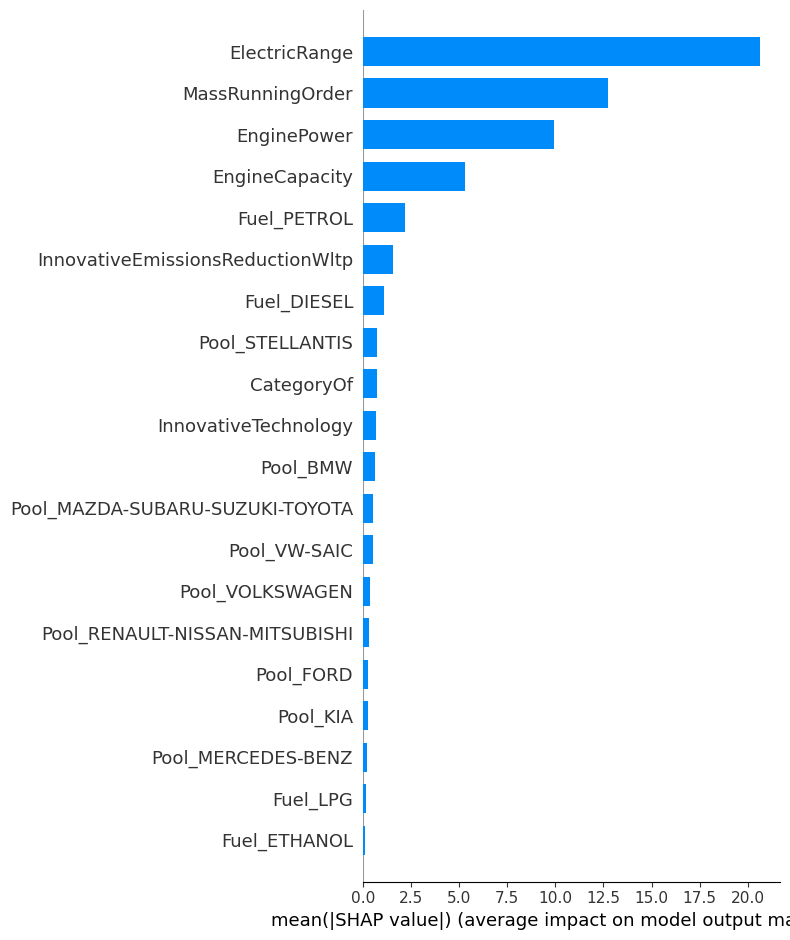

In [250]:
# feature importance: methode shap_values
# Trouver le moyen d'ecrire les scores

shap_graph = shap.summary_plot(shap_values, X_test, plot_type="bar")

In [264]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")



In [ ]:
plots

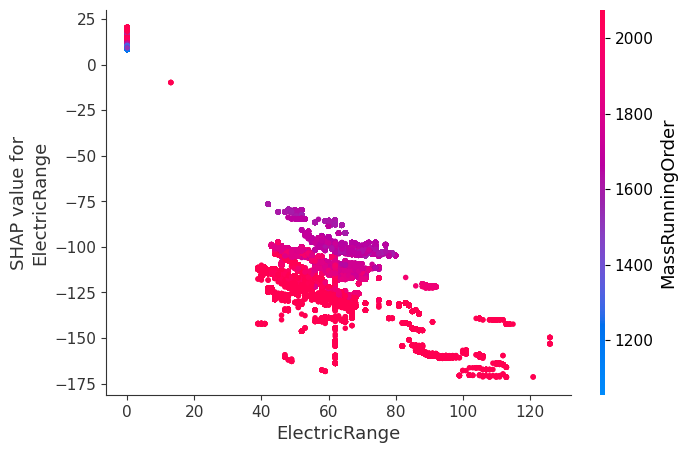

In [ ]:
# Les graphiques de dépendance de SHAP montrent l'effet d'une variable sur l'ensemble des données
shap.dependence_plot("ElectricRange", shap_values, X_test, interaction_index= "MassRunningOrder")

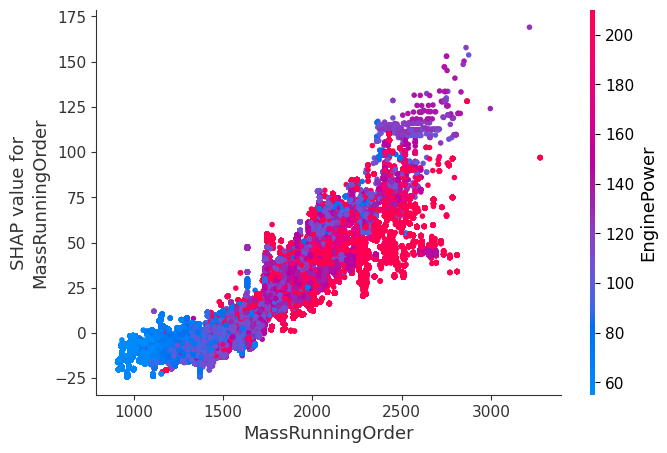

In [ ]:
shap.dependence_plot("MassRunningOrder", shap_values, X_test, interaction_index= "EnginePower")

### Essayons de créer notre propre modèle de substitution, à partir des prédictions de notre modèle XGBoost.
- Est ce vraiment interessant pour de la regression linéaire ?

In [ ]:
# Récupération des prédictions

# pred_test = model.predict(test)
# pred_train = model.predict(train)

#Entraînement du modèle
sg_clf = LinearRegression()
sg_clf.fit(X_train, pred_train)

# Scores du modèle
sg_clf.score(X_test, y_test)
# print(classification_report(y_test, sg_clf.predict(X_test)))

# #Comparaison des prédictions
# print(sum(preds!=sg_clf.predict(X_train)))

# # Comparaison des prédictions sur le jeu de test
# probs = bst.predict(dtest)
# preds = [0 if x<0.5 else 1 for x in probs]

# print(sum(preds!=sg_clf.predict(X_test))/len(X_test))

0.8932318356810817

In [ ]:
# Coef de Features les plus importants (en Val Absolue):
# Transform en df avec aussi la VA
# Faire un graphique

features = X_train.columns.tolist()
coefs = sg_clf.coef_.tolist()
coefs_va = [abs(valeur) for valeur in coefs]

feature_imp = pd.DataFrame({'VA du coef': coefs_va, 'coefs': coefs}, index=features).sort_values(by = 'VA du coef', ascending = False)
feature_imp.head(15)

,VA du coef,coefs
Fuel_DIESEL/ELECTRIC,85.593991,-85.593991
Fuel_PETROL/ELECTRIC,58.474990,-58.474990
Fuel_PETROL,34.773217,34.773217
Fuel_NATURALGAS,28.079843,28.079843
Fuel_LPG,26.935031,26.935031
Fuel_ETHANOL,24.905103,24.905103
Fuel_DIESEL,23.000823,23.000823
Pool_MAZDA-SUBARU-SUZUKI-TOYOTA,8.211020,-8.211020
Pool_BMW,7.695225,-7.695225
Fuel_NG,6.374964,6.374964


# XGBoosting – (Extreme Gradient Boosting) - Version 2

In [ ]:
b# Preparation des données - train/valid/test

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 3)

train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

# tps de calcul = 10s

In [188]:
# Preparation des données - train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)


# tps de calcul = 6s

In [ ]:
## Faut il normaliser ?
# Data normalization is not necessary for decision trees. Since XGBoost is based on decision trees, is it necessary to do data normalization using

In [189]:
# Model XGB. Fit + Score
# Parametres "rapides"

temps_debut = time.time()

params = {'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 200, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'test')] )
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

preds = model.predict(test)


# fit time
temps_fin = time.time()
duree_execution = temps_fin - temps_debut
print(f"Le code a pris {duree_execution} secondes pour s'exécuter.")


# Commentaire:
# le code prends 120s sur Colab_CPU
# rmse = 3,05

# 18/01 - FrAl21
# le code prends 160s sur Colab_CPU
# rmse = 2,75

[11:12:09] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.68089	test-rmse:10.66243
[1]	train-rmse:8.98375	test-rmse:8.96253
[2]	train-rmse:8.77467	test-rmse:8.74939
[3]	train-rmse:8.05115	test-rmse:8.02866
[4]	train-rmse:7.36996	test-rmse:7.35959
[5]	train-rmse:6.97871	test-rmse:6.96753
[6]	train-rmse:6.61433	test-rmse:6.60841
[7]	train-rmse:6.34454	test-rmse:6.33039
[8]	train-rmse:6.19920	test-rmse:6.18632
[9]	train-rmse:6.01939	test-rmse:6.00368
[10]	train-rmse:5.81109	test-rmse:5.79575
[11]	train-rmse:5.58319	test-rmse:5.56763
[12]	train-rmse:5.44773	test-rmse:5.43389
[13]	train-rmse:5.27980	test-rmse:5.26527
[14]	train-rmse:5.17532	test-rmse:5.16404
[15]	train-rmse:5.10707	test-rmse:5.09466
[16]	train-rmse:4.98693	test-rmse:4.97391
[17]	train-rmse:4.94380	test-rmse:4.92962
[18]	train-rmse:4.91097	test-rmse:4.89548
[19]	train-rmse:4.82885	test-rmse:4